### Deadline 2022-06-27 23:59:59

# Первая нейросетка

Ну что ж, пришло время построить свою первую нейронную сеть. У нас будет искуственная задачка и мы посмотрим на её примере, как работают различные алгоритмы машинного обучения.

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
% matplotlib inline

In [3]:
df = pd.read_csv('data.csv', index_col=0)

Как и в любой задаче машинного обучения для начала надо визуализировать данные. 
Не зря же нашу нейронную сеть мы так долго учим?


<AxesSubplot:xlabel='x1', ylabel='x2'>

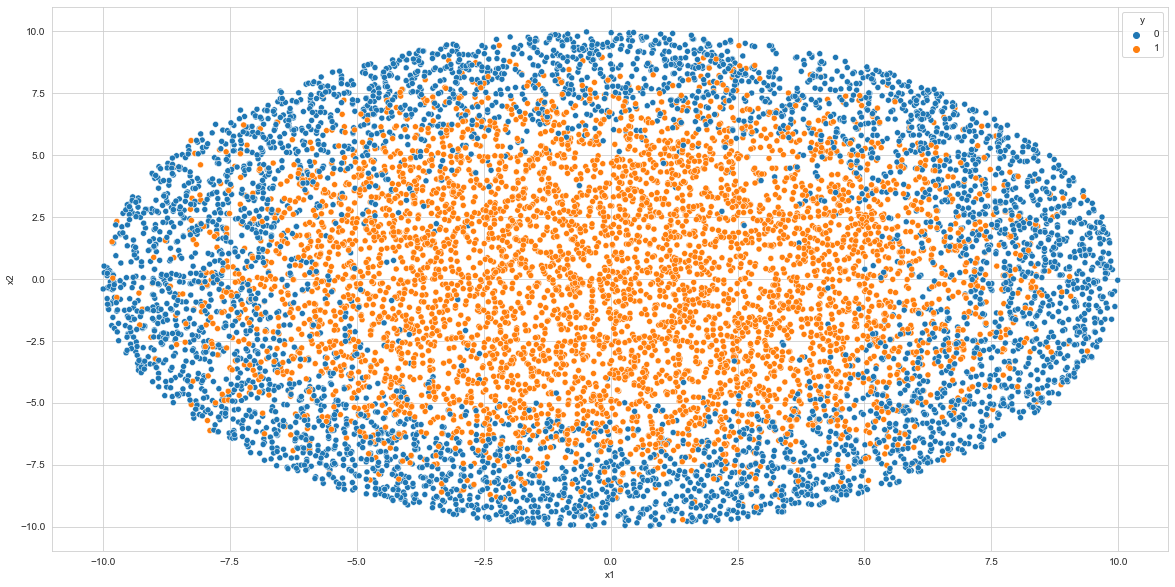

In [4]:
plt.figure(figsize=(20, 10))
sns.scatterplot(x="x1", y="x2", hue="y", data=df)

После просмотра данных встает несколько вопросов:
 * 1) Можем ли мы построить идеальную модель ? (условная метрика точность)
 * 2) Что ещё мы хотим знать о выборке?
 * 3) Какие алгоритмы машинного обучения мы можем эффективно здесь использовать?

После описательного анализа приступим к построению моделей. Для начала посмотрим, что нам даст Логистическая регрессия. 

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# разобьем выборку на трэйн/тест
X_train, X_test, y_train, y_test = train_test_split(df[['x1', 'x2']], df['y'], test_size=0.33)

Точность нашей модели 0.5996969696969697


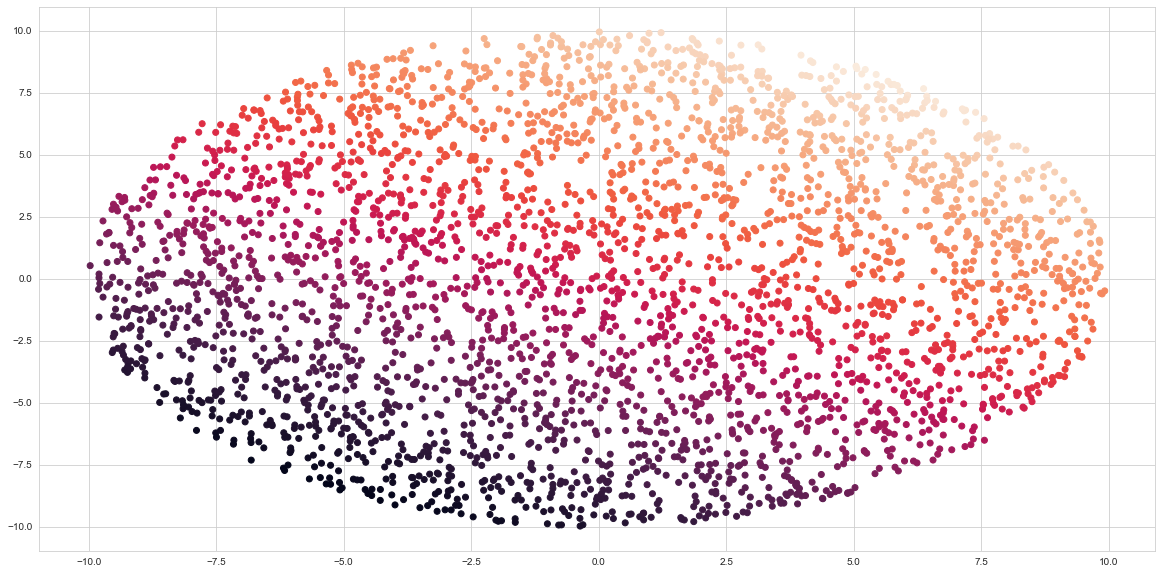

In [6]:
from sklearn.linear_model import LogisticRegression

#########################################
# Ваш код для Логистической регрессии

lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)

predict_logit = lr_model.predict(X_test)
predict_log_proba = lr_model.predict_log_proba(X_test)[:, 1]

#########################################


print(f'Точность нашей модели {accuracy_score(predict_logit, y_test)}')

# Заодно завизуализируем полученные результаты
plt.figure(figsize=(20, 10))
plt.scatter(X_test['x1'], X_test['x2'], c=predict_log_proba)
plt.show()

Вообще машинное обучение не только про алгоритмы (нейронные сети не исключение),
 а скорее про обработку данных. Что нам надо добавить, чтобы наш алгоритм отработал без проблем?

In [7]:
df.head(5)

x1        x2  y
0 -4.626272 -6.658988  0
1 -7.789640  0.262519  0
2 -8.739678  1.537758  0
3 -2.546441 -7.705224  0
4 -2.751506 -7.940187  0

In [8]:
df.describe()

x1            x2             y
count  10000.000000  10000.000000  10000.000000
mean      -0.029488     -0.098799      0.509700
std        4.981907      5.022414      0.499931
min       -9.988732     -9.972095      0.000000
25%       -4.062951     -4.170403      0.000000
50%       -0.063085     -0.097836      1.000000
75%        4.016095      3.880448      1.000000
max        9.985560      9.982304      1.000000

Точность нашей модели 0.576060606060606


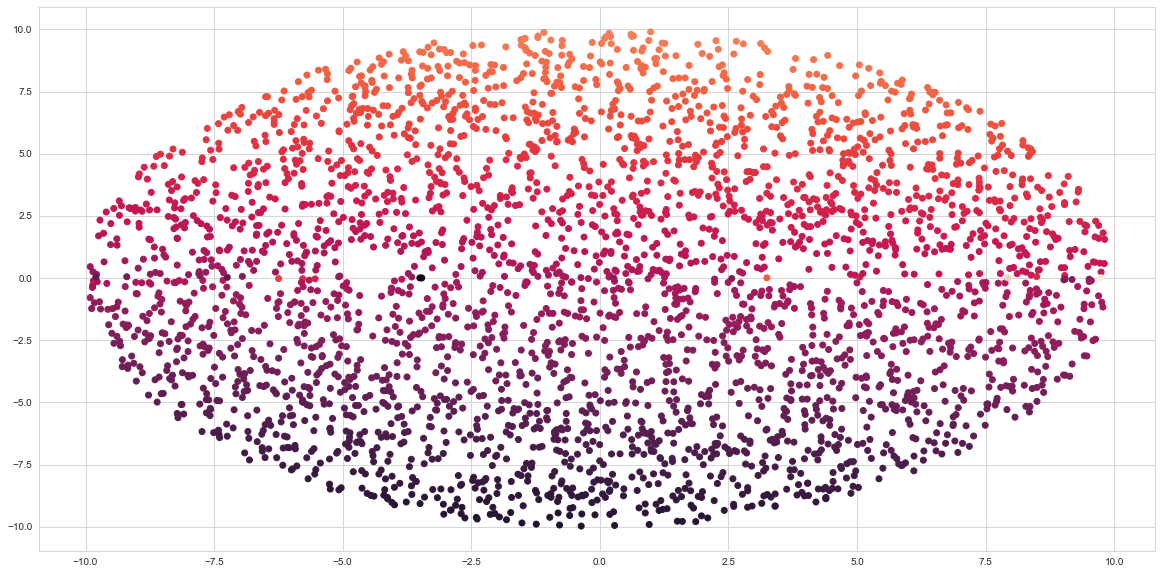

In [9]:
# Повторяем наш код, только с новыми фичами - смотрим на магию
df_new = df.copy()

#########################################
# ваш код для фичей и новой модели

df_new['new_feature_1'] = df_new['x1'] / df_new['x2']

X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(df_new[['x1', 'x2', 'new_feature_1']],
                                                                    df_new['y'], test_size=0.33)
lr_model_new = LogisticRegression()
lr_model_new.fit(X_train_new, y_train_new)
predict_logit = lr_model_new.predict(X_test_new)
predict_log_proba = lr_model_new.predict_log_proba(X_test_new)[:, 1]

#########################################

print(f'Точность нашей модели {accuracy_score(predict_logit, y_test_new)}')

plt.figure(figsize=(20, 10))
plt.scatter(X_test_new['x1'], X_test_new['x2'], c=predict_log_proba)
plt.show()

Для того, чтоб совсем не списывать со счетов линейную регрессию, попробуем оптимизировать гиперпараметры с помощью библиотеки optuna

In [10]:
!pip install optuna
import optuna

# находим оптимальные параметры с помощью optuna

def lr_model_new_tr(trial: optuna.Trial) -> float:
    mi = trial.suggest_int(name='max_iter', low=100, high=100000)
    tl = trial.suggest_float(name='tol', low=1e-4, high=1)
    c = trial.suggest_float(name='C', low=1e-10, high=1000)
    cw = trial.suggest_categorical(name='class_weight', choices=['balanced', None])

    lr_model_mule = LogisticRegression(penalty='l2', max_iter=mi, tol=tl, C=c, class_weight=cw, solver='lbfgs').fit(
        X_train_new, y_train_new)
    pr = lr_model_mule.predict(X_test_new)
    score = accuracy_score(pr, y_test_new)

    return score


lr_study = optuna.create_study(direction='maximize')
lr_study.optimize(lr_model_new_tr, n_trials=1000)

Улучшили результат модели!

Точность нашей модели 0.576060606060606


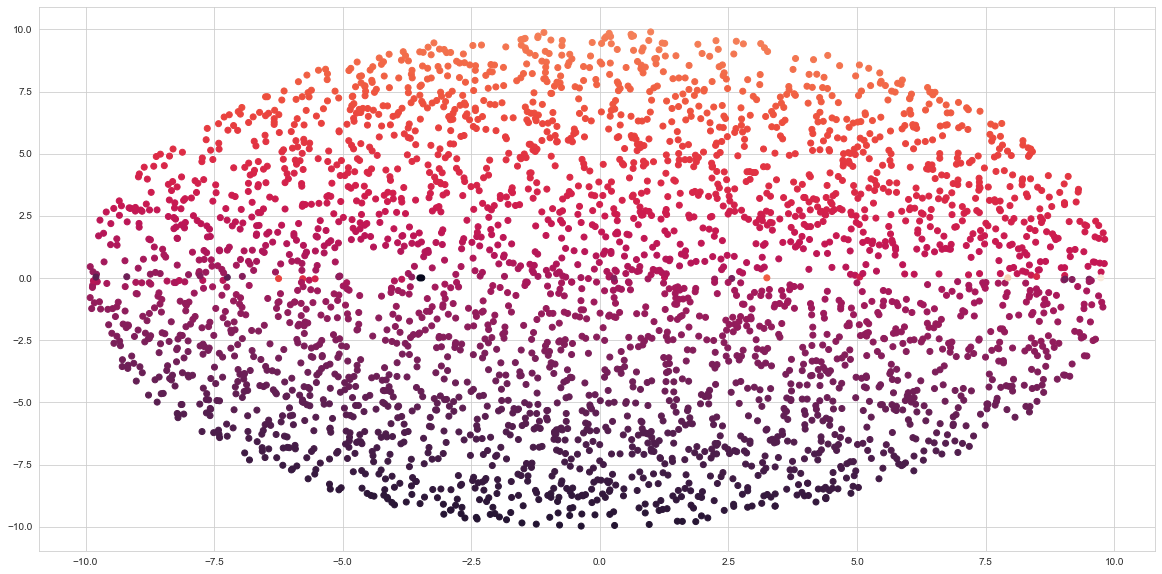

In [11]:
# подобранные optuna параметры:
# {'max_iter': 37228, 'tol': 0.18600712367470443, 'C': 0.006745990048031558, 'class_weight': None}.

lr_model_neo = LogisticRegression(max_iter=37228, tol=0.18600712367470443, C=0.006745990048031558, class_weight=None)
lr_model_neo.fit(X_train_new, y_train_new)
predict_logit = lr_model_neo.predict(X_test_new)
predict_log_proba = lr_model_neo.predict_log_proba(X_test_new)[:, 1]

#########################################

print(f'Точность нашей модели {accuracy_score(predict_logit, y_test_new)}')

plt.figure(figsize=(20, 10))
plt.scatter(X_test_new['x1'], X_test_new['x2'], c=predict_log_proba)
plt.show()

Переходим к следующему классу алгоритмов - деревья решений. Какая особенность есть у деревьев? Какой параметр надо зафиксировать, чтобы эта особенность не испортила обучение?

In [12]:
from sklearn.tree import DecisionTreeClassifier

# с помощью optuna оптимизируем глубину
def tree_model_tr(trial: optuna.Trial) -> float:
    sp = trial.suggest_categorical(name='splitter', choices=['best', 'random'])
    md = trial.suggest_int(name='max_depth', low=1, high=100, step=1)
    ms = trial.suggest_int(name='min_samples_split', low=2, high=10, step=1)

    tree_model_mule = DecisionTreeClassifier(splitter=sp, max_depth=md, min_samples_split=ms, criterion='gini').fit(
        X_train, y_train)
    pr = tree_model_mule.predict(X_test)
    return accuracy_score(pr, y_test)


tree_study = optuna.create_study(direction='maximize')
tree_study.optimize(tree_model_tr, n_trials=1000)


Точность нашей модели 0.8187878787878788


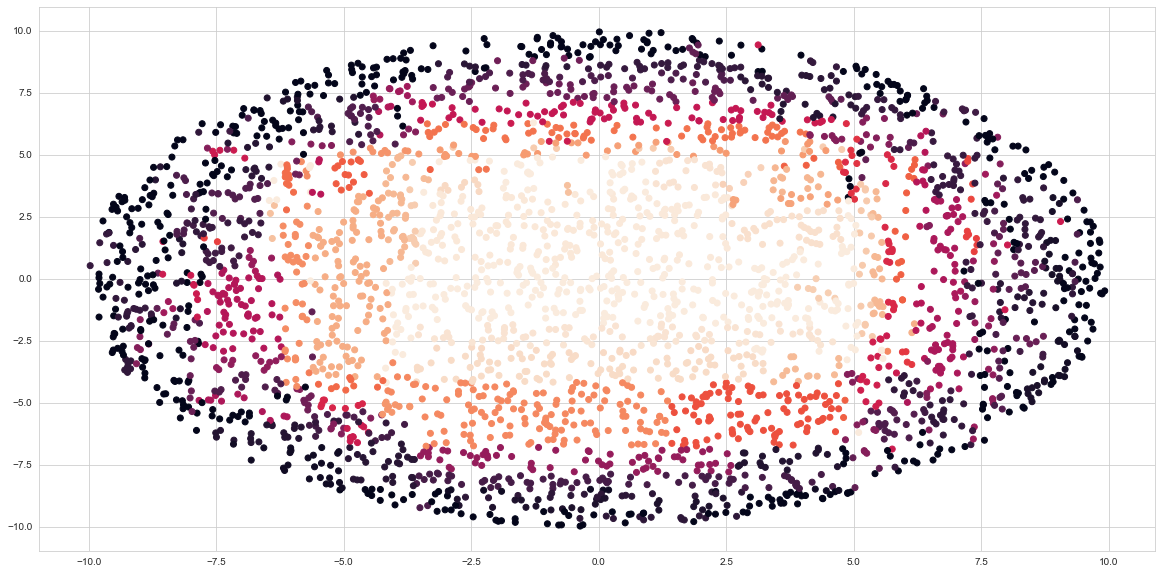

In [13]:
#########################################
# Ваш код

# optuna подсказала: 'splitter': 'random', 'max_depth': 11, 'min_samples_split': 10
tree_model = DecisionTreeClassifier(splitter='random', max_depth=11, min_samples_split=10)
tree_model.fit(X_train, y_train)

predict_tree = tree_model.predict(X_test)
print(f'Точность нашей модели {accuracy_score(predict_tree, y_test)}')

predict_tree_proba = tree_model.predict_proba(X_test)[:, 1]

#########################################

plt.figure(figsize=(20, 10))
plt.scatter(X_test['x1'], X_test['x2'], c=predict_tree_proba)
plt.show()

Поможет ли в данном случае ансамблирование? Когда в целом ансамбль дает хорошие результаты?

In [14]:
from sklearn.ensemble import RandomForestClassifier

# очень нравится optuna применю её и здесь
def forest_model_tr(trial: optuna.Trial) -> float:
    n = trial.suggest_int(name='n_estimators', low=10, high=1000)
    ms = trial.suggest_int(name='min_samples_split', low=2, high=10, step=1)
    md = trial.suggest_int(name='max_depth', low=1, high=100, step=1)
    bs = trial.suggest_categorical(name='bootstrap', choices=[True, False])

    forest_model_mule = RandomForestClassifier(n_estimators=n, criterion='gini', min_samples_split=ms, max_depth=md,
                                               bootstrap=bs).fit(X_train, y_train)
    pr = forest_model_mule.predict(X_test)
    return accuracy_score(pr, y_test)


forest_study = optuna.create_study(direction='maximize')
forest_study.optimize(forest_model_tr, n_trials=100)

Точность нашей модели 0.8266666666666667


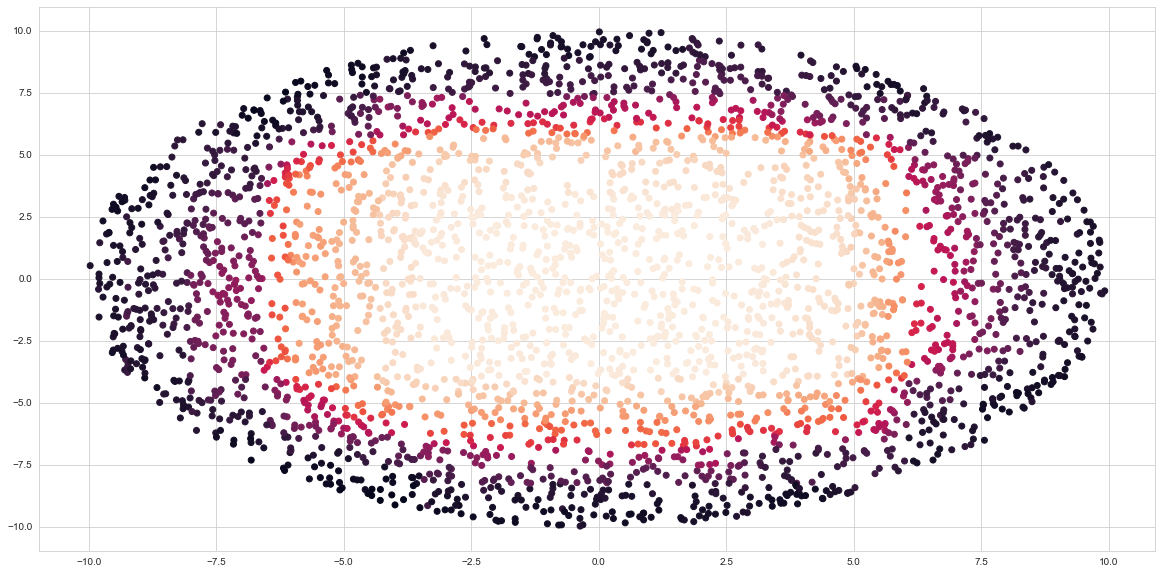

In [15]:
#########################################
# Ваш код

# optuna подсказала: 'n_estimators': 706, 'min_samples_split': 10, 'max_depth': 7, 'bootstrap': True
n = 706
ms = 10
md = 7
bs = True
forest_model = RandomForestClassifier(n_estimators=n, criterion='gini', min_samples_split=ms, max_depth=md,
                                      bootstrap=bs)
forest_model.fit(X_train, y_train)
predict_forest = forest_model.predict(X_test)
print(f'Точность нашей модели {accuracy_score(predict_forest, y_test)}')

predict_forest_proba = forest_model.predict_proba(X_test)[:, 1]

#########################################

plt.figure(figsize=(20, 10))
plt.scatter(X_test['x1'], X_test['x2'], c=predict_forest_proba)
plt.show()

ну и наконец мы добрались до нейронок - пора собрать нашу нейроночку под эту задачу.

Соберем простенькую нейронку - нам хватит 2х слоев по 5 нейронов в каждом. Смотрим на предыдущую тетрадку и копипастим все, что мы там видим! (можно для убыстрения процесса добавить callback с ранней остановкой)

In [16]:
!pip install tensorflow

In [17]:
# Подгружаем tensorflow 
import tensorflow as tf

keras = tf.keras

print(tf.__version__)
print(keras.__version__)

from tensorflow.keras.models import Sequential  # Последовательность слоёв
import tensorflow.keras.layers as L  # Разные слои
import tensorflow.keras.optimizers as opt  # Оптимизаторы

2.9.1
2.9.0


На этом наше приключение сегодня закончилось. Вопросы максимально желательны :)

2022-06-27 15:09:59.059500: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


104/104 [==============================] - 0s 798us/step
Точность нашей модели 0.5042424242424243


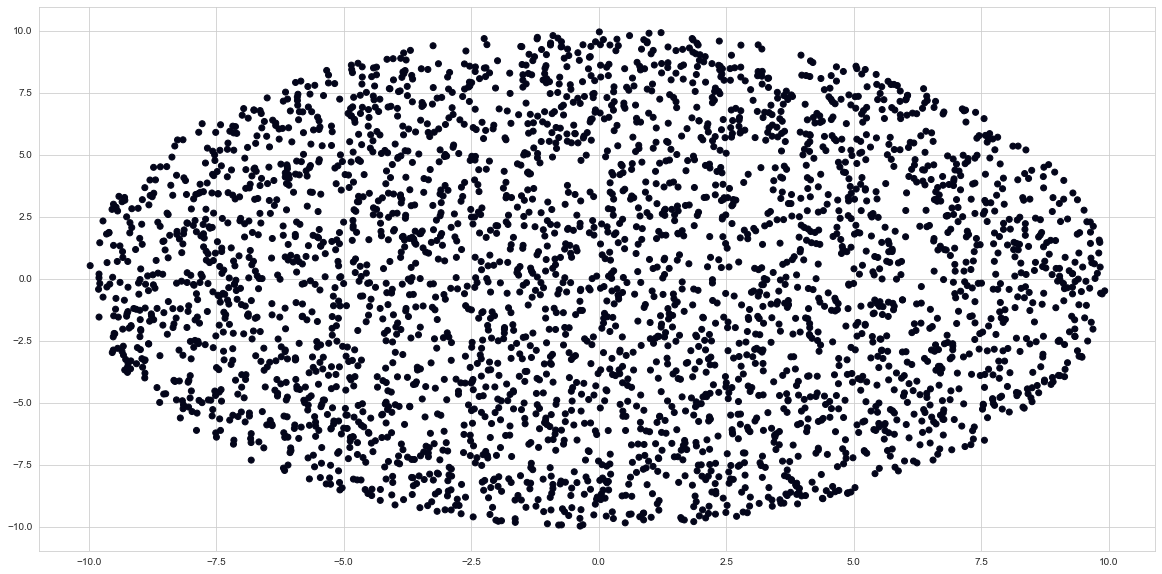

In [18]:
#########################################
# Ваш код

def get_neural_model():
    neural_model = Sequential()
    neural_model.add(L.Dense(5, input_dim=X_test.shape[1], kernel_initializer='random_normal'))
    neural_model.add(L.Activation('sigmoid'))
    neural_model.add(L.Dense(5, kernel_initializer='random_normal'))
    neural_model.add(L.Activation('sigmoid'))
    neural_model.add(L.Dense(2, activation='softmax', kernel_initializer='random_normal'))
    optimizer = opt.Adam(learning_rate=1e-3)

    neural_model.compile(loss='sparse_categorical_crossentropy', metrics=['accuracy'], optimizer=optimizer)

    return neural_model


my_first_neural_model = get_neural_model()
my_first_neural_model.fit(X_train, y_train)

predict_neural = my_first_neural_model.predict(X_test)
predict_classes = tf.argmax(predict_neural, axis=1).numpy()

print(f'Точность нашей модели {accuracy_score(predict_classes, y_test)}')
#########################################

plt.figure(figsize=(20, 10))
plt.scatter(X_test['x1'], X_test['x2'], c=predict_classes)
plt.show()

Epoch 1/38
210/210 [==============================] - 1s 1ms/step - loss: 0.6910 - accuracy: 0.5530
Epoch 2/38
210/210 [==============================] - 0s 1ms/step - loss: 0.6855 - accuracy: 0.5761
Epoch 3/38
210/210 [==============================] - 0s 926us/step - loss: 0.6792 - accuracy: 0.5793
Epoch 4/38
210/210 [==============================] - 0s 903us/step - loss: 0.6749 - accuracy: 0.5796
Epoch 5/38
210/210 [==============================] - 0s 862us/step - loss: 0.6691 - accuracy: 0.5906
Epoch 6/38
210/210 [==============================] - 0s 924us/step - loss: 0.6649 - accuracy: 0.5897
Epoch 7/38
210/210 [==============================] - 0s 896us/step - loss: 0.6625 - accuracy: 0.5931
Epoch 8/38
210/210 [==============================] - 0s 1ms/step - loss: 0.6571 - accuracy: 0.5990
Epoch 9/38
210/210 [==============================] - 0s 914us/step - loss: 0.6532 - accuracy: 0.6073
Epoch 10/38
210/210 [==============================] - 0s 858us/step - loss: 0.6556 - ac

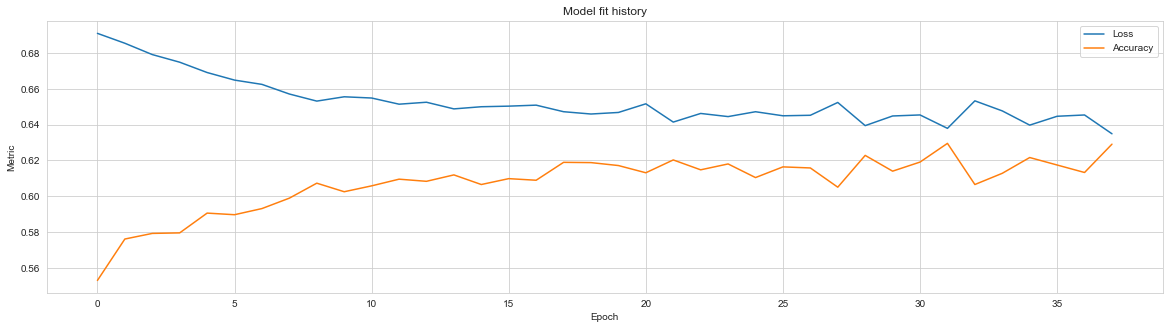

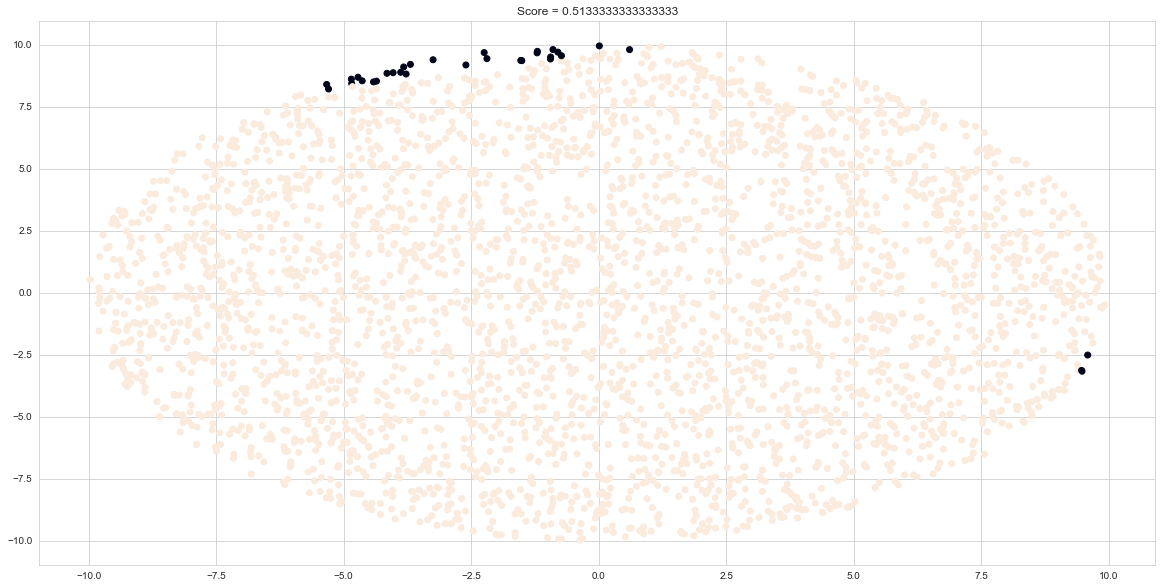

In [19]:
# предыдущая сеть - действительно первая нейронная сеть написанная мной по принципу copy->paste и заставь работать,
# однако результат её назвать удовлетворительным нельзя, поэтому проведу работу над улучшением её результата
from sklearn.preprocessing import StandardScaler


#########################################

def get_neural_model_neo():
    neural_model = Sequential()

    neural_model.add(L.Input(shape=X_test.shape[1]))

    neural_model.add(L.Dense(5, activation='relu', kernel_initializer='random_normal'))
    neural_model.add(L.Dropout(0.5))
    neural_model.add(L.Dense(5, activation='relu', kernel_initializer='random_normal'))
    neural_model.add(L.Dropout(0.5))

    neural_model.add(L.Dense(2, activation='sigmoid'))

    optimizer = 'rmsprop'
    neural_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    return neural_model


std_scaler = StandardScaler()
std_scaler = std_scaler.fit(X_train)
X_train_std = std_scaler.transform(X_train)
X_test_std = std_scaler.transform(X_test)

my_first_neural_model = get_neural_model_neo()
fit_log = my_first_neural_model.fit(X_train_std, keras.utils.to_categorical(y_train), epochs=38, workers=4, verbose=1)

predict_neural = my_first_neural_model.predict(X_test_std)
predict_classes = tf.argmax(predict_neural, axis=1).numpy()

score = accuracy_score(predict_classes, y_test)

print(f'Точность нашей модели {score}')
#########################################
plt.figure(figsize=(20, 5))
plt.title(f'Model fit history')
plt.xlabel('Epoch')
plt.ylabel('Metric')
plt.plot(fit_log.history['loss'], label='Loss')
plt.plot(fit_log.history['accuracy'], label='Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(20, 10))
plt.title(f'Score = {score}')
plt.scatter(X_test['x1'], X_test['x2'], c=predict_classes)
plt.show()

In [29]:
# оптимизация с помощью optuna
def get_neural_model_optimized(trial: optuna.Trial) -> Sequential():
    activator_choices = ['relu', 'sigmoid', 'softmax', 'tanh']

    kernel_initializer_choices = ['random_normal', 'random_uniform', 'zeros', 'ones']

    opt_activator1 = trial.suggest_categorical(name='activation', choices=activator_choices)
    opt_activator2 = trial.suggest_categorical(name='activation', choices=activator_choices)
    opt_activator3 = trial.suggest_categorical(name='activation', choices=activator_choices)
    opt_kernel_init1 = trial.suggest_categorical(name='kernel_initializer', choices=kernel_initializer_choices)
    opt_kernel_init2 = trial.suggest_categorical(name='kernel_initializer', choices=kernel_initializer_choices)

    neural_model = Sequential()

    neural_model.add(L.Input(shape=X_test.shape[1]))

    neural_model.add(L.Dense(5, activation=opt_activator1, kernel_initializer=opt_kernel_init1))
    neural_model.add(L.Dropout(0.5))
    neural_model.add(L.Dense(5, activation=opt_activator2, kernel_initializer=opt_kernel_init2))
    neural_model.add(L.Dropout(0.5))
    neural_model.add(L.Dense(2, activation=opt_activator3))

    optimizer = 'rmsprop'
    neural_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    return neural_model


def neuro_model_tr(trial: optuna.Trial) -> float:
    keras.backend.clear_session()
    opt_batch_size = trial.suggest_int(name='batch_size', low=30, high=150)
    opt_epoch_count = trial.suggest_int(name='epochs', low=30, high=100)

    neuro_model = get_neural_model_optimized(trial)

    neuro_model.fit(X_train_std, keras.utils.to_categorical(y_train), batch_size=opt_batch_size, epochs=38, workers=4,
                    verbose=1)

    score = neuro_model.evaluate(X_test_std, keras.utils.to_categorical(y_test), verbose=0)
    return score[1]


study = optuna.create_study(direction="maximize")
study.optimize(neuro_model_tr, n_trials=100)

[I 2022-06-27 15:23:32,179] A new study created in memory with name: no-name-7deb9a5a-55ca-4c85-9d38-d9c815a9e1b4


Epoch 1/38
47/47 [==============================] - 0s 926us/step - loss: 0.8388 - accuracy: 0.4852
Epoch 2/38
47/47 [==============================] - 0s 993us/step - loss: 0.7873 - accuracy: 0.4940
Epoch 3/38
47/47 [==============================] - 0s 971us/step - loss: 0.7520 - accuracy: 0.5070
Epoch 4/38
47/47 [==============================] - 0s 957us/step - loss: 0.7397 - accuracy: 0.4924
Epoch 5/38
47/47 [==============================] - 0s 989us/step - loss: 0.7229 - accuracy: 0.4967
Epoch 6/38
47/47 [==============================] - 0s 980us/step - loss: 0.7167 - accuracy: 0.4999
Epoch 7/38
47/47 [==============================] - 0s 1ms/step - loss: 0.7121 - accuracy: 0.4919
Epoch 8/38
47/47 [==============================] - 0s 1ms/step - loss: 0.7080 - accuracy: 0.4934
Epoch 9/38
47/47 [==============================] - 0s 959us/step - loss: 0.7059 - accuracy: 0.4985
Epoch 10/38
47/47 [==============================] - 0s 954us/step - loss: 0.7030 - accuracy: 0.4997
Epo

[I 2022-06-27 15:23:34,645] Trial 0 finished with value: 0.5042424201965332 and parameters: {'batch_size': 145, 'epochs': 51, 'activation': 'sigmoid', 'kernel_initializer': 'random_normal'}. Best is trial 0 with value: 0.5042424201965332.


Epoch 1/38
70/70 [==============================] - 1s 1ms/step - loss: 0.7125 - accuracy: 0.4949
Epoch 2/38
70/70 [==============================] - 0s 970us/step - loss: 0.7053 - accuracy: 0.4936
Epoch 3/38
70/70 [==============================] - 0s 935us/step - loss: 0.7016 - accuracy: 0.4939
Epoch 4/38
70/70 [==============================] - 0s 1ms/step - loss: 0.6986 - accuracy: 0.4978
Epoch 5/38
70/70 [==============================] - 0s 941us/step - loss: 0.6971 - accuracy: 0.5042
Epoch 6/38
70/70 [==============================] - 0s 966us/step - loss: 0.6970 - accuracy: 0.4978
Epoch 7/38
70/70 [==============================] - 0s 943us/step - loss: 0.6954 - accuracy: 0.5158
Epoch 8/38
70/70 [==============================] - 0s 985us/step - loss: 0.6962 - accuracy: 0.5042
Epoch 9/38
70/70 [==============================] - 0s 874us/step - loss: 0.6957 - accuracy: 0.5049
Epoch 10/38
70/70 [==============================] - 0s 883us/step - loss: 0.6963 - accuracy: 0.5069
Epo

[I 2022-06-27 15:23:37,862] Trial 1 finished with value: 0.5042424201965332 and parameters: {'batch_size': 96, 'epochs': 63, 'activation': 'softmax', 'kernel_initializer': 'random_uniform'}. Best is trial 0 with value: 0.5042424201965332.


Epoch 1/38
71/71 [==============================] - 0s 928us/step - loss: 0.8300 - accuracy: 0.4966
Epoch 2/38
71/71 [==============================] - 0s 935us/step - loss: 0.7863 - accuracy: 0.4967
Epoch 3/38
71/71 [==============================] - 0s 899us/step - loss: 0.7579 - accuracy: 0.5010
Epoch 4/38
71/71 [==============================] - 0s 953us/step - loss: 0.7463 - accuracy: 0.4957
Epoch 5/38
71/71 [==============================] - 0s 902us/step - loss: 0.7274 - accuracy: 0.5057
Epoch 6/38
71/71 [==============================] - 0s 979us/step - loss: 0.7205 - accuracy: 0.5003
Epoch 7/38
71/71 [==============================] - 0s 877us/step - loss: 0.7097 - accuracy: 0.5082
Epoch 8/38
71/71 [==============================] - 0s 961us/step - loss: 0.7101 - accuracy: 0.4978
Epoch 9/38
71/71 [==============================] - 0s 849us/step - loss: 0.7032 - accuracy: 0.5063
Epoch 10/38
71/71 [==============================] - 0s 857us/step - loss: 0.7006 - accuracy: 0.5003

[I 2022-06-27 15:23:40,946] Trial 2 finished with value: 0.5042424201965332 and parameters: {'batch_size': 95, 'epochs': 73, 'activation': 'sigmoid', 'kernel_initializer': 'ones'}. Best is trial 0 with value: 0.5042424201965332.


Epoch 1/38
56/56 [==============================] - 0s 984us/step - loss: 7.7125 - accuracy: 0.4876
Epoch 2/38
56/56 [==============================] - 0s 992us/step - loss: 7.7125 - accuracy: 0.4876
Epoch 3/38
56/56 [==============================] - 0s 1ms/step - loss: 7.7125 - accuracy: 0.4876
Epoch 4/38
56/56 [==============================] - 0s 948us/step - loss: 7.7125 - accuracy: 0.4876
Epoch 5/38
56/56 [==============================] - 0s 983us/step - loss: 7.7125 - accuracy: 0.4876
Epoch 6/38
56/56 [==============================] - 0s 1ms/step - loss: 7.7125 - accuracy: 0.4876
Epoch 7/38
56/56 [==============================] - 0s 1ms/step - loss: 7.7125 - accuracy: 0.4876
Epoch 8/38
56/56 [==============================] - 0s 955us/step - loss: 7.7125 - accuracy: 0.4876
Epoch 9/38
56/56 [==============================] - 0s 961us/step - loss: 7.7125 - accuracy: 0.4876
Epoch 10/38
56/56 [==============================] - 0s 866us/step - loss: 7.7125 - accuracy: 0.4876
Epoch

[I 2022-06-27 15:23:43,639] Trial 3 finished with value: 0.4957575798034668 and parameters: {'batch_size': 120, 'epochs': 73, 'activation': 'relu', 'kernel_initializer': 'zeros'}. Best is trial 0 with value: 0.5042424201965332.


Epoch 1/38
79/79 [==============================] - 1s 943us/step - loss: 7.7125 - accuracy: 0.4876
Epoch 2/38
79/79 [==============================] - 0s 957us/step - loss: 7.7125 - accuracy: 0.4876
Epoch 3/38
79/79 [==============================] - 0s 904us/step - loss: 7.7125 - accuracy: 0.4876
Epoch 4/38
79/79 [==============================] - 0s 933us/step - loss: 7.7125 - accuracy: 0.4876
Epoch 5/38
79/79 [==============================] - 0s 902us/step - loss: 7.7125 - accuracy: 0.4876
Epoch 6/38
79/79 [==============================] - 0s 941us/step - loss: 7.7125 - accuracy: 0.4876
Epoch 7/38
79/79 [==============================] - 0s 945us/step - loss: 7.7125 - accuracy: 0.4876
Epoch 8/38
79/79 [==============================] - 0s 894us/step - loss: 7.7125 - accuracy: 0.4876
Epoch 9/38
79/79 [==============================] - 0s 974us/step - loss: 7.7125 - accuracy: 0.4876
Epoch 10/38
79/79 [==============================] - 0s 858us/step - loss: 7.7125 - accuracy: 0.4876

[I 2022-06-27 15:23:47,386] Trial 4 finished with value: 0.4957575798034668 and parameters: {'batch_size': 85, 'epochs': 91, 'activation': 'tanh', 'kernel_initializer': 'zeros'}. Best is trial 0 with value: 0.5042424201965332.


Epoch 1/38
52/52 [==============================] - 0s 952us/step - loss: 0.6995 - accuracy: 0.5027
Epoch 2/38
52/52 [==============================] - 0s 1ms/step - loss: 0.6993 - accuracy: 0.4937
Epoch 3/38
52/52 [==============================] - 0s 959us/step - loss: 0.6969 - accuracy: 0.5103
Epoch 4/38
52/52 [==============================] - 0s 934us/step - loss: 0.6971 - accuracy: 0.4993
Epoch 5/38
52/52 [==============================] - 0s 1ms/step - loss: 0.6969 - accuracy: 0.4996
Epoch 6/38
52/52 [==============================] - 0s 979us/step - loss: 0.6960 - accuracy: 0.5006
Epoch 7/38
52/52 [==============================] - 0s 945us/step - loss: 0.6964 - accuracy: 0.4981
Epoch 8/38
52/52 [==============================] - 0s 948us/step - loss: 0.6959 - accuracy: 0.4943
Epoch 9/38
52/52 [==============================] - 0s 955us/step - loss: 0.6946 - accuracy: 0.5106
Epoch 10/38
52/52 [==============================] - 0s 868us/step - loss: 0.6955 - accuracy: 0.5040
Epo

[I 2022-06-27 15:23:49,890] Trial 5 finished with value: 0.5042424201965332 and parameters: {'batch_size': 131, 'epochs': 46, 'activation': 'softmax', 'kernel_initializer': 'random_normal'}. Best is trial 0 with value: 0.5042424201965332.


Epoch 1/38
67/67 [==============================] - 0s 945us/step - loss: 0.8430 - accuracy: 0.5069
Epoch 2/38
67/67 [==============================] - 0s 938us/step - loss: 0.7868 - accuracy: 0.5178
Epoch 3/38
67/67 [==============================] - 0s 939us/step - loss: 0.7635 - accuracy: 0.5082
Epoch 4/38
67/67 [==============================] - 0s 954us/step - loss: 0.7413 - accuracy: 0.4936
Epoch 5/38
67/67 [==============================] - 0s 926us/step - loss: 0.7334 - accuracy: 0.4930
Epoch 6/38
67/67 [==============================] - 0s 946us/step - loss: 0.7200 - accuracy: 0.5040
Epoch 7/38
67/67 [==============================] - 0s 976us/step - loss: 0.7145 - accuracy: 0.4973
Epoch 8/38
67/67 [==============================] - 0s 949us/step - loss: 0.7070 - accuracy: 0.5042
Epoch 9/38
67/67 [==============================] - 0s 878us/step - loss: 0.7043 - accuracy: 0.5128
Epoch 10/38
67/67 [==============================] - 0s 876us/step - loss: 0.7008 - accuracy: 0.5010

[I 2022-06-27 15:23:52,851] Trial 6 finished with value: 0.5981818437576294 and parameters: {'batch_size': 101, 'epochs': 57, 'activation': 'sigmoid', 'kernel_initializer': 'ones'}. Best is trial 6 with value: 0.5981818437576294.


Epoch 1/38
182/182 [==============================] - 1s 890us/step - loss: 4.7769 - accuracy: 0.4867
Epoch 2/38
182/182 [==============================] - 0s 870us/step - loss: 4.3479 - accuracy: 0.4876
Epoch 3/38
182/182 [==============================] - 0s 900us/step - loss: 4.3051 - accuracy: 0.4876
Epoch 4/38
182/182 [==============================] - 0s 874us/step - loss: 4.2989 - accuracy: 0.4876
Epoch 5/38
182/182 [==============================] - 0s 878us/step - loss: 4.2959 - accuracy: 0.4876
Epoch 6/38
182/182 [==============================] - 0s 974us/step - loss: 4.2942 - accuracy: 0.4876
Epoch 7/38
182/182 [==============================] - 0s 907us/step - loss: 4.2908 - accuracy: 0.4876
Epoch 8/38
182/182 [==============================] - 0s 874us/step - loss: 4.2906 - accuracy: 0.4876
Epoch 9/38
182/182 [==============================] - 0s 854us/step - loss: 4.2899 - accuracy: 0.4876
Epoch 10/38
182/182 [==============================] - 0s 827us/step - loss: 4.289

[I 2022-06-27 15:23:59,355] Trial 7 finished with value: 0.4957575798034668 and parameters: {'batch_size': 37, 'epochs': 62, 'activation': 'relu', 'kernel_initializer': 'random_normal'}. Best is trial 6 with value: 0.5981818437576294.


Epoch 1/38
46/46 [==============================] - 1s 2ms/step - loss: 2.3825 - accuracy: 0.5113
Epoch 2/38
46/46 [==============================] - 0s 1ms/step - loss: 1.6907 - accuracy: 0.5130
Epoch 3/38
46/46 [==============================] - 0s 1ms/step - loss: 1.2454 - accuracy: 0.5172
Epoch 4/38
46/46 [==============================] - 0s 942us/step - loss: 0.9943 - accuracy: 0.5146
Epoch 5/38
46/46 [==============================] - 0s 1ms/step - loss: 0.8711 - accuracy: 0.5091
Epoch 6/38
46/46 [==============================] - 0s 927us/step - loss: 0.8057 - accuracy: 0.5110
Epoch 7/38
46/46 [==============================] - 0s 951us/step - loss: 0.7646 - accuracy: 0.5212
Epoch 8/38
46/46 [==============================] - 0s 1ms/step - loss: 0.7436 - accuracy: 0.5133
Epoch 9/38
46/46 [==============================] - 0s 972us/step - loss: 0.7229 - accuracy: 0.5246
Epoch 10/38
46/46 [==============================] - 0s 947us/step - loss: 0.7115 - accuracy: 0.5231
Epoch 11/

[I 2022-06-27 15:24:01,799] Trial 8 finished with value: 0.7921212315559387 and parameters: {'batch_size': 146, 'epochs': 50, 'activation': 'relu', 'kernel_initializer': 'random_uniform'}. Best is trial 8 with value: 0.7921212315559387.


Epoch 1/38
59/59 [==============================] - 0s 1ms/step - loss: 0.7047 - accuracy: 0.4984
Epoch 2/38
59/59 [==============================] - 0s 1ms/step - loss: 0.6994 - accuracy: 0.5131
Epoch 3/38
59/59 [==============================] - 0s 1ms/step - loss: 0.6989 - accuracy: 0.5096
Epoch 4/38
59/59 [==============================] - 0s 1ms/step - loss: 0.6988 - accuracy: 0.5064
Epoch 5/38
59/59 [==============================] - 0s 951us/step - loss: 0.6984 - accuracy: 0.4955
Epoch 6/38
59/59 [==============================] - 0s 969us/step - loss: 0.6981 - accuracy: 0.5004
Epoch 7/38
59/59 [==============================] - 0s 1ms/step - loss: 0.6970 - accuracy: 0.5043
Epoch 8/38
59/59 [==============================] - 0s 971us/step - loss: 0.6962 - accuracy: 0.5045
Epoch 9/38
59/59 [==============================] - 0s 1ms/step - loss: 0.6962 - accuracy: 0.5010
Epoch 10/38
59/59 [==============================] - 0s 889us/step - loss: 0.6969 - accuracy: 0.4903
Epoch 11/38

[I 2022-06-27 15:24:04,599] Trial 9 finished with value: 0.5042424201965332 and parameters: {'batch_size': 115, 'epochs': 39, 'activation': 'softmax', 'kernel_initializer': 'random_normal'}. Best is trial 8 with value: 0.7921212315559387.


Epoch 1/38
120/120 [==============================] - 1s 916us/step - loss: 1.4747 - accuracy: 0.5055
Epoch 2/38
120/120 [==============================] - 0s 936us/step - loss: 0.8538 - accuracy: 0.5016
Epoch 3/38
120/120 [==============================] - 0s 928us/step - loss: 0.7539 - accuracy: 0.5164
Epoch 4/38
120/120 [==============================] - 0s 933us/step - loss: 0.7186 - accuracy: 0.5197
Epoch 5/38
120/120 [==============================] - 0s 923us/step - loss: 0.7007 - accuracy: 0.5193
Epoch 6/38
120/120 [==============================] - 0s 935us/step - loss: 0.6910 - accuracy: 0.5460
Epoch 7/38
120/120 [==============================] - 0s 968us/step - loss: 0.6869 - accuracy: 0.5457
Epoch 8/38
120/120 [==============================] - 0s 943us/step - loss: 0.6828 - accuracy: 0.5558
Epoch 9/38
120/120 [==============================] - 0s 888us/step - loss: 0.6799 - accuracy: 0.5667
Epoch 10/38
120/120 [==============================] - 0s 857us/step - loss: 0.676

[I 2022-06-27 15:24:09,346] Trial 10 finished with value: 0.5042424201965332 and parameters: {'batch_size': 56, 'epochs': 30, 'activation': 'relu', 'kernel_initializer': 'random_uniform'}. Best is trial 8 with value: 0.7921212315559387.


Epoch 1/38
95/95 [==============================] - 1s 976us/step - loss: 0.8893 - accuracy: 0.4915
Epoch 2/38
95/95 [==============================] - 0s 918us/step - loss: 0.8067 - accuracy: 0.4893
Epoch 3/38
95/95 [==============================] - 0s 946us/step - loss: 0.7582 - accuracy: 0.4906
Epoch 4/38
95/95 [==============================] - 0s 998us/step - loss: 0.7343 - accuracy: 0.4913
Epoch 5/38
95/95 [==============================] - 0s 939us/step - loss: 0.7198 - accuracy: 0.5075
Epoch 6/38
95/95 [==============================] - 0s 936us/step - loss: 0.7110 - accuracy: 0.5070
Epoch 7/38
95/95 [==============================] - 0s 926us/step - loss: 0.7050 - accuracy: 0.5119
Epoch 8/38
95/95 [==============================] - 0s 926us/step - loss: 0.7009 - accuracy: 0.5113
Epoch 9/38
95/95 [==============================] - 0s 918us/step - loss: 0.6981 - accuracy: 0.5116
Epoch 10/38
95/95 [==============================] - 0s 872us/step - loss: 0.6964 - accuracy: 0.5133

[I 2022-06-27 15:24:13,284] Trial 11 finished with value: 0.5796969532966614 and parameters: {'batch_size': 71, 'epochs': 54, 'activation': 'sigmoid', 'kernel_initializer': 'ones'}. Best is trial 8 with value: 0.7921212315559387.


Epoch 1/38
45/45 [==============================] - 0s 953us/step - loss: 4.2489 - accuracy: 0.4904
Epoch 2/38
45/45 [==============================] - 0s 984us/step - loss: 4.1223 - accuracy: 0.5016
Epoch 3/38
45/45 [==============================] - 0s 949us/step - loss: 3.9409 - accuracy: 0.5054
Epoch 4/38
45/45 [==============================] - 0s 1ms/step - loss: 3.7256 - accuracy: 0.4969
Epoch 5/38
45/45 [==============================] - 0s 888us/step - loss: 3.5817 - accuracy: 0.4979
Epoch 6/38
45/45 [==============================] - 0s 1ms/step - loss: 3.4310 - accuracy: 0.5034
Epoch 7/38
45/45 [==============================] - 0s 957us/step - loss: 3.0489 - accuracy: 0.4982
Epoch 8/38
45/45 [==============================] - 0s 1ms/step - loss: 2.8061 - accuracy: 0.4973
Epoch 9/38
45/45 [==============================] - 0s 980us/step - loss: 2.5083 - accuracy: 0.5113
Epoch 10/38
45/45 [==============================] - 0s 922us/step - loss: 2.2266 - accuracy: 0.4960
Epoch

[I 2022-06-27 15:24:15,622] Trial 12 finished with value: 0.5787878632545471 and parameters: {'batch_size': 150, 'epochs': 85, 'activation': 'tanh', 'kernel_initializer': 'ones'}. Best is trial 8 with value: 0.7921212315559387.


Epoch 1/38
61/61 [==============================] - 1s 964us/step - loss: 1.7319 - accuracy: 0.5097
Epoch 2/38
61/61 [==============================] - 0s 960us/step - loss: 1.0452 - accuracy: 0.5067
Epoch 3/38
61/61 [==============================] - 0s 1ms/step - loss: 0.8415 - accuracy: 0.5184
Epoch 4/38
61/61 [==============================] - 0s 934us/step - loss: 0.7785 - accuracy: 0.5128
Epoch 5/38
61/61 [==============================] - 0s 969us/step - loss: 0.7442 - accuracy: 0.5178
Epoch 6/38
61/61 [==============================] - 0s 957us/step - loss: 0.7255 - accuracy: 0.5203
Epoch 7/38
61/61 [==============================] - 0s 975us/step - loss: 0.7116 - accuracy: 0.5128
Epoch 8/38
61/61 [==============================] - 0s 979us/step - loss: 0.7035 - accuracy: 0.5133
Epoch 9/38
61/61 [==============================] - 0s 941us/step - loss: 0.6979 - accuracy: 0.5240
Epoch 10/38
61/61 [==============================] - 0s 889us/step - loss: 0.6937 - accuracy: 0.5255
E

[I 2022-06-27 15:24:18,574] Trial 13 finished with value: 0.553636372089386 and parameters: {'batch_size': 111, 'epochs': 42, 'activation': 'relu', 'kernel_initializer': 'random_uniform'}. Best is trial 8 with value: 0.7921212315559387.


Epoch 1/38
52/52 [==============================] - 0s 975us/step - loss: 0.7457 - accuracy: 0.5012
Epoch 2/38
52/52 [==============================] - 0s 967us/step - loss: 0.7254 - accuracy: 0.5028
Epoch 3/38
52/52 [==============================] - 0s 959us/step - loss: 0.7146 - accuracy: 0.5063
Epoch 4/38
52/52 [==============================] - 0s 921us/step - loss: 0.7121 - accuracy: 0.4884
Epoch 5/38
52/52 [==============================] - 0s 1ms/step - loss: 0.7051 - accuracy: 0.5018
Epoch 6/38
52/52 [==============================] - 0s 910us/step - loss: 0.7023 - accuracy: 0.5043
Epoch 7/38
52/52 [==============================] - 0s 1ms/step - loss: 0.7017 - accuracy: 0.5009
Epoch 8/38
52/52 [==============================] - 0s 969us/step - loss: 0.6997 - accuracy: 0.5003
Epoch 9/38
52/52 [==============================] - 0s 976us/step - loss: 0.6975 - accuracy: 0.5028
Epoch 10/38
52/52 [==============================] - 0s 906us/step - loss: 0.6986 - accuracy: 0.4994
Epo

[I 2022-06-27 15:24:21,399] Trial 14 finished with value: 0.5042424201965332 and parameters: {'batch_size': 131, 'epochs': 58, 'activation': 'sigmoid', 'kernel_initializer': 'random_uniform'}. Best is trial 8 with value: 0.7921212315559387.


Epoch 1/38
105/105 [==============================] - 1s 962us/step - loss: 4.0265 - accuracy: 0.4961
Epoch 2/38
105/105 [==============================] - 0s 909us/step - loss: 3.6328 - accuracy: 0.4949
Epoch 3/38
105/105 [==============================] - 0s 935us/step - loss: 3.5119 - accuracy: 0.4897
Epoch 4/38
105/105 [==============================] - 0s 987us/step - loss: 3.4433 - accuracy: 0.5012
Epoch 5/38
105/105 [==============================] - 0s 983us/step - loss: 3.3778 - accuracy: 0.4913
Epoch 6/38
105/105 [==============================] - 0s 953us/step - loss: 3.2474 - accuracy: 0.4942
Epoch 7/38
105/105 [==============================] - 0s 961us/step - loss: 3.1697 - accuracy: 0.5015
Epoch 8/38
105/105 [==============================] - 0s 920us/step - loss: 3.0361 - accuracy: 0.5155
Epoch 9/38
105/105 [==============================] - 0s 975us/step - loss: 3.0723 - accuracy: 0.5043
Epoch 10/38
105/105 [==============================] - 0s 899us/step - loss: 2.990

[I 2022-06-27 15:24:25,954] Trial 15 finished with value: 0.5709090828895569 and parameters: {'batch_size': 64, 'epochs': 72, 'activation': 'relu', 'kernel_initializer': 'ones'}. Best is trial 8 with value: 0.7921212315559387.


Epoch 1/38
198/198 [==============================] - 1s 961us/step - loss: 0.8075 - accuracy: 0.4960
Epoch 2/38
198/198 [==============================] - 0s 860us/step - loss: 0.7603 - accuracy: 0.5039
Epoch 3/38
198/198 [==============================] - 0s 979us/step - loss: 0.7418 - accuracy: 0.4981
Epoch 4/38
198/198 [==============================] - 0s 915us/step - loss: 0.7165 - accuracy: 0.5052
Epoch 5/38
198/198 [==============================] - 0s 978us/step - loss: 0.7058 - accuracy: 0.5043
Epoch 6/38
198/198 [==============================] - 0s 881us/step - loss: 0.7009 - accuracy: 0.5028
Epoch 7/38
198/198 [==============================] - 0s 869us/step - loss: 0.6975 - accuracy: 0.5031
Epoch 8/38
198/198 [==============================] - 0s 972us/step - loss: 0.6954 - accuracy: 0.5155
Epoch 9/38
198/198 [==============================] - 0s 859us/step - loss: 0.6959 - accuracy: 0.5010
Epoch 10/38
198/198 [==============================] - 0s 845us/step - loss: 0.692

[I 2022-06-27 15:24:33,462] Trial 16 finished with value: 0.5990909337997437 and parameters: {'batch_size': 34, 'epochs': 32, 'activation': 'sigmoid', 'kernel_initializer': 'ones'}. Best is trial 8 with value: 0.7921212315559387.


Epoch 1/38
187/187 [==============================] - 1s 961us/step - loss: 1.2598 - accuracy: 0.5057
Epoch 2/38
187/187 [==============================] - 0s 885us/step - loss: 0.7504 - accuracy: 0.5115
Epoch 3/38
187/187 [==============================] - 0s 941us/step - loss: 0.7119 - accuracy: 0.5078
Epoch 4/38
187/187 [==============================] - 0s 889us/step - loss: 0.7031 - accuracy: 0.5024
Epoch 5/38
187/187 [==============================] - 0s 885us/step - loss: 0.6977 - accuracy: 0.5093
Epoch 6/38
187/187 [==============================] - 0s 964us/step - loss: 0.6961 - accuracy: 0.4999
Epoch 7/38
187/187 [==============================] - 0s 854us/step - loss: 0.6944 - accuracy: 0.5116
Epoch 8/38
187/187 [==============================] - 0s 861us/step - loss: 0.6937 - accuracy: 0.5199
Epoch 9/38
187/187 [==============================] - 0s 967us/step - loss: 0.6933 - accuracy: 0.5207
Epoch 10/38
187/187 [==============================] - 0s 830us/step - loss: 0.693

[I 2022-06-27 15:24:40,878] Trial 17 finished with value: 0.5639393925666809 and parameters: {'batch_size': 36, 'epochs': 31, 'activation': 'tanh', 'kernel_initializer': 'random_uniform'}. Best is trial 8 with value: 0.7921212315559387.


Epoch 1/38
129/129 [==============================] - 1s 1ms/step - loss: 7.7125 - accuracy: 0.4876
Epoch 2/38
129/129 [==============================] - 0s 1ms/step - loss: 7.7125 - accuracy: 0.4876
Epoch 3/38
129/129 [==============================] - 0s 1ms/step - loss: 7.7125 - accuracy: 0.4876
Epoch 4/38
129/129 [==============================] - 0s 1ms/step - loss: 7.7125 - accuracy: 0.4876
Epoch 5/38
129/129 [==============================] - 0s 1ms/step - loss: 7.7125 - accuracy: 0.4876
Epoch 6/38
129/129 [==============================] - 0s 1ms/step - loss: 7.7125 - accuracy: 0.4876
Epoch 7/38
129/129 [==============================] - 0s 1ms/step - loss: 7.7125 - accuracy: 0.4876
Epoch 8/38
129/129 [==============================] - 0s 1ms/step - loss: 7.7125 - accuracy: 0.4876
Epoch 9/38
129/129 [==============================] - 0s 1ms/step - loss: 7.7125 - accuracy: 0.4876
Epoch 10/38
129/129 [==============================] - 0s 971us/step - loss: 7.7125 - accuracy: 0.48

[I 2022-06-27 15:24:46,835] Trial 18 finished with value: 0.4957575798034668 and parameters: {'batch_size': 52, 'epochs': 37, 'activation': 'relu', 'kernel_initializer': 'zeros'}. Best is trial 8 with value: 0.7921212315559387.


Epoch 1/38
88/88 [==============================] - 1s 1ms/step - loss: 0.7119 - accuracy: 0.4948
Epoch 2/38
88/88 [==============================] - 0s 977us/step - loss: 0.7023 - accuracy: 0.4994
Epoch 3/38
88/88 [==============================] - 0s 964us/step - loss: 0.6977 - accuracy: 0.5061
Epoch 4/38
88/88 [==============================] - 0s 966us/step - loss: 0.6977 - accuracy: 0.5009
Epoch 5/38
88/88 [==============================] - 0s 973us/step - loss: 0.6958 - accuracy: 0.5061
Epoch 6/38
88/88 [==============================] - 0s 955us/step - loss: 0.6954 - accuracy: 0.5016
Epoch 7/38
88/88 [==============================] - 0s 1ms/step - loss: 0.6948 - accuracy: 0.5063
Epoch 8/38
88/88 [==============================] - 0s 971us/step - loss: 0.6942 - accuracy: 0.5066
Epoch 9/38
88/88 [==============================] - 0s 907us/step - loss: 0.6943 - accuracy: 0.5009
Epoch 10/38
88/88 [==============================] - 0s 943us/step - loss: 0.6941 - accuracy: 0.5018
Epo

[I 2022-06-27 15:24:50,800] Trial 19 finished with value: 0.5042424201965332 and parameters: {'batch_size': 77, 'epochs': 46, 'activation': 'sigmoid', 'kernel_initializer': 'random_uniform'}. Best is trial 8 with value: 0.7921212315559387.


Epoch 1/38
224/224 [==============================] - 1s 1ms/step - loss: 3.7139 - accuracy: 0.4994
Epoch 2/38
224/224 [==============================] - 0s 977us/step - loss: 3.1631 - accuracy: 0.5037
Epoch 3/38
224/224 [==============================] - 0s 1ms/step - loss: 2.9434 - accuracy: 0.5119
Epoch 4/38
224/224 [==============================] - 0s 979us/step - loss: 2.6643 - accuracy: 0.5196
Epoch 5/38
224/224 [==============================] - 0s 1ms/step - loss: 2.6926 - accuracy: 0.5136
Epoch 6/38
224/224 [==============================] - 0s 993us/step - loss: 2.5496 - accuracy: 0.5251
Epoch 7/38
224/224 [==============================] - 0s 1ms/step - loss: 2.5380 - accuracy: 0.5210
Epoch 8/38
224/224 [==============================] - 0s 998us/step - loss: 2.4593 - accuracy: 0.5236
Epoch 9/38
224/224 [==============================] - 0s 961us/step - loss: 2.4033 - accuracy: 0.5282
Epoch 10/38
224/224 [==============================] - 0s 955us/step - loss: 2.2710 - accu

[I 2022-06-27 15:25:00,355] Trial 20 finished with value: 0.6021212339401245 and parameters: {'batch_size': 30, 'epochs': 36, 'activation': 'relu', 'kernel_initializer': 'ones'}. Best is trial 8 with value: 0.7921212315559387.


Epoch 1/38
149/149 [==============================] - 1s 1ms/step - loss: 5.1314 - accuracy: 0.4897
Epoch 2/38
149/149 [==============================] - 0s 1ms/step - loss: 4.7445 - accuracy: 0.5079
Epoch 3/38
149/149 [==============================] - 0s 1ms/step - loss: 4.5723 - accuracy: 0.4996
Epoch 4/38
149/149 [==============================] - 0s 1ms/step - loss: 4.4657 - accuracy: 0.5076
Epoch 5/38
149/149 [==============================] - 0s 1ms/step - loss: 3.9020 - accuracy: 0.5079
Epoch 6/38
149/149 [==============================] - 0s 1ms/step - loss: 3.3459 - accuracy: 0.5030
Epoch 7/38
149/149 [==============================] - 0s 1ms/step - loss: 3.1941 - accuracy: 0.5115
Epoch 8/38
149/149 [==============================] - 0s 1ms/step - loss: 3.1203 - accuracy: 0.5161
Epoch 9/38
149/149 [==============================] - 0s 1ms/step - loss: 3.0111 - accuracy: 0.5119
Epoch 10/38
149/149 [==============================] - 0s 1ms/step - loss: 2.9451 - accuracy: 0.5155

[I 2022-06-27 15:25:07,466] Trial 21 finished with value: 0.5903030037879944 and parameters: {'batch_size': 45, 'epochs': 35, 'activation': 'relu', 'kernel_initializer': 'ones'}. Best is trial 8 with value: 0.7921212315559387.


Epoch 1/38
217/217 [==============================] - 1s 1ms/step - loss: 4.0308 - accuracy: 0.5072
Epoch 2/38
217/217 [==============================] - 0s 1ms/step - loss: 3.6324 - accuracy: 0.5001
Epoch 3/38
217/217 [==============================] - 0s 1ms/step - loss: 3.4755 - accuracy: 0.5210
Epoch 4/38
217/217 [==============================] - 0s 1ms/step - loss: 3.4122 - accuracy: 0.5045
Epoch 5/38
217/217 [==============================] - 0s 1ms/step - loss: 3.2881 - accuracy: 0.5099
Epoch 6/38
217/217 [==============================] - 0s 1ms/step - loss: 3.2717 - accuracy: 0.5127
Epoch 7/38
217/217 [==============================] - 0s 1ms/step - loss: 3.2151 - accuracy: 0.5093
Epoch 8/38
217/217 [==============================] - 0s 1ms/step - loss: 3.2181 - accuracy: 0.5170
Epoch 9/38
217/217 [==============================] - 0s 1ms/step - loss: 3.1296 - accuracy: 0.5221
Epoch 10/38
217/217 [==============================] - 0s 1ms/step - loss: 2.9998 - accuracy: 0.5291

[I 2022-06-27 15:25:17,925] Trial 22 finished with value: 0.5763636231422424 and parameters: {'batch_size': 31, 'epochs': 46, 'activation': 'relu', 'kernel_initializer': 'ones'}. Best is trial 8 with value: 0.7921212315559387.


Epoch 1/38
153/153 [==============================] - 1s 1ms/step - loss: 4.2981 - accuracy: 0.4988
Epoch 2/38
153/153 [==============================] - 0s 1ms/step - loss: 3.5441 - accuracy: 0.5082
Epoch 3/38
153/153 [==============================] - 0s 1ms/step - loss: 3.2288 - accuracy: 0.5160
Epoch 4/38
153/153 [==============================] - 0s 1ms/step - loss: 3.0623 - accuracy: 0.5104
Epoch 5/38
153/153 [==============================] - 0s 1ms/step - loss: 2.9894 - accuracy: 0.5128
Epoch 6/38
153/153 [==============================] - 0s 1ms/step - loss: 2.8021 - accuracy: 0.5170
Epoch 7/38
153/153 [==============================] - 0s 1ms/step - loss: 2.7373 - accuracy: 0.5204
Epoch 8/38
153/153 [==============================] - 0s 1ms/step - loss: 2.6630 - accuracy: 0.5187
Epoch 9/38
153/153 [==============================] - 0s 1ms/step - loss: 2.6683 - accuracy: 0.5216
Epoch 10/38
153/153 [==============================] - 0s 1ms/step - loss: 2.5890 - accuracy: 0.5212

[I 2022-06-27 15:25:25,654] Trial 23 finished with value: 0.5787878632545471 and parameters: {'batch_size': 44, 'epochs': 35, 'activation': 'relu', 'kernel_initializer': 'ones'}. Best is trial 8 with value: 0.7921212315559387.


Epoch 1/38
110/110 [==============================] - 1s 1ms/step - loss: 5.8862 - accuracy: 0.4891
Epoch 2/38
110/110 [==============================] - 0s 1ms/step - loss: 5.5648 - accuracy: 0.4924
Epoch 3/38
110/110 [==============================] - 0s 1ms/step - loss: 4.0146 - accuracy: 0.4963
Epoch 4/38
110/110 [==============================] - 0s 1ms/step - loss: 3.5235 - accuracy: 0.4991
Epoch 5/38
110/110 [==============================] - 0s 1ms/step - loss: 3.3158 - accuracy: 0.5028
Epoch 6/38
110/110 [==============================] - 0s 1ms/step - loss: 3.1761 - accuracy: 0.5018
Epoch 7/38
110/110 [==============================] - 0s 1ms/step - loss: 3.1906 - accuracy: 0.5096
Epoch 8/38
110/110 [==============================] - 0s 1ms/step - loss: 3.0410 - accuracy: 0.5176
Epoch 9/38
110/110 [==============================] - 0s 1ms/step - loss: 3.0330 - accuracy: 0.5236
Epoch 10/38
110/110 [==============================] - 0s 1ms/step - loss: 2.8436 - accuracy: 0.5263

[I 2022-06-27 15:25:31,607] Trial 24 finished with value: 0.5630303025245667 and parameters: {'batch_size': 61, 'epochs': 42, 'activation': 'relu', 'kernel_initializer': 'ones'}. Best is trial 8 with value: 0.7921212315559387.


Epoch 1/38
224/224 [==============================] - 1s 1ms/step - loss: 0.8381 - accuracy: 0.5133
Epoch 2/38
224/224 [==============================] - 0s 1ms/step - loss: 0.7788 - accuracy: 0.5064
Epoch 3/38
224/224 [==============================] - 0s 1ms/step - loss: 0.7413 - accuracy: 0.5103
Epoch 4/38
224/224 [==============================] - 0s 1ms/step - loss: 0.7181 - accuracy: 0.5079
Epoch 5/38
224/224 [==============================] - 0s 1ms/step - loss: 0.7090 - accuracy: 0.5072
Epoch 6/38
224/224 [==============================] - 0s 1ms/step - loss: 0.7015 - accuracy: 0.5028
Epoch 7/38
224/224 [==============================] - 0s 1ms/step - loss: 0.6965 - accuracy: 0.5119
Epoch 8/38
224/224 [==============================] - 0s 1ms/step - loss: 0.6949 - accuracy: 0.5084
Epoch 9/38
224/224 [==============================] - 0s 1ms/step - loss: 0.6953 - accuracy: 0.5124
Epoch 10/38
224/224 [==============================] - 0s 1ms/step - loss: 0.6935 - accuracy: 0.5224

[I 2022-06-27 15:25:42,082] Trial 25 finished with value: 0.5936363339424133 and parameters: {'batch_size': 30, 'epochs': 48, 'activation': 'sigmoid', 'kernel_initializer': 'ones'}. Best is trial 8 with value: 0.7921212315559387.


Epoch 1/38
140/140 [==============================] - 1s 1ms/step - loss: 1.3948 - accuracy: 0.4875
Epoch 2/38
140/140 [==============================] - 0s 1ms/step - loss: 0.7850 - accuracy: 0.4897
Epoch 3/38
140/140 [==============================] - 0s 1ms/step - loss: 0.7322 - accuracy: 0.4854
Epoch 4/38
140/140 [==============================] - 0s 1ms/step - loss: 0.7128 - accuracy: 0.5031
Epoch 5/38
140/140 [==============================] - 0s 1ms/step - loss: 0.7040 - accuracy: 0.5018
Epoch 6/38
140/140 [==============================] - 0s 1ms/step - loss: 0.6995 - accuracy: 0.5064
Epoch 7/38
140/140 [==============================] - 0s 1ms/step - loss: 0.6968 - accuracy: 0.5084
Epoch 8/38
140/140 [==============================] - 0s 1ms/step - loss: 0.6951 - accuracy: 0.5125
Epoch 9/38
140/140 [==============================] - 0s 1ms/step - loss: 0.6940 - accuracy: 0.5163
Epoch 10/38
140/140 [==============================] - 0s 1ms/step - loss: 0.6939 - accuracy: 0.5176

[I 2022-06-27 15:25:48,762] Trial 26 finished with value: 0.5042424201965332 and parameters: {'batch_size': 48, 'epochs': 40, 'activation': 'tanh', 'kernel_initializer': 'random_uniform'}. Best is trial 8 with value: 0.7921212315559387.


Epoch 1/38
80/80 [==============================] - 1s 1ms/step - loss: 0.7009 - accuracy: 0.5069
Epoch 2/38
80/80 [==============================] - 0s 1ms/step - loss: 0.7009 - accuracy: 0.5034
Epoch 3/38
80/80 [==============================] - 0s 1ms/step - loss: 0.6973 - accuracy: 0.5145
Epoch 4/38
80/80 [==============================] - 0s 1ms/step - loss: 0.6985 - accuracy: 0.4984
Epoch 5/38
80/80 [==============================] - 0s 1ms/step - loss: 0.6979 - accuracy: 0.5024
Epoch 6/38
80/80 [==============================] - 0s 1ms/step - loss: 0.6962 - accuracy: 0.5072
Epoch 7/38
80/80 [==============================] - 0s 1ms/step - loss: 0.6958 - accuracy: 0.5104
Epoch 8/38
80/80 [==============================] - 0s 1ms/step - loss: 0.6959 - accuracy: 0.5060
Epoch 9/38
80/80 [==============================] - 0s 1ms/step - loss: 0.6957 - accuracy: 0.5145
Epoch 10/38
80/80 [==============================] - 0s 1ms/step - loss: 0.6960 - accuracy: 0.5021
Epoch 11/38
80/80 [

[I 2022-06-27 15:25:53,062] Trial 27 finished with value: 0.5727272629737854 and parameters: {'batch_size': 84, 'epochs': 31, 'activation': 'softmax', 'kernel_initializer': 'zeros'}. Best is trial 8 with value: 0.7921212315559387.


Epoch 1/38
98/98 [==============================] - 1s 1ms/step - loss: 4.2178 - accuracy: 0.4967
Epoch 2/38
98/98 [==============================] - 0s 1ms/step - loss: 3.6283 - accuracy: 0.5090
Epoch 3/38
98/98 [==============================] - 0s 1ms/step - loss: 3.5631 - accuracy: 0.5076
Epoch 4/38
98/98 [==============================] - 0s 1ms/step - loss: 3.4694 - accuracy: 0.4925
Epoch 5/38
98/98 [==============================] - 0s 1ms/step - loss: 3.4371 - accuracy: 0.5109
Epoch 6/38
98/98 [==============================] - 0s 1ms/step - loss: 3.4187 - accuracy: 0.5094
Epoch 7/38
98/98 [==============================] - 0s 1ms/step - loss: 3.3815 - accuracy: 0.5094
Epoch 8/38
98/98 [==============================] - 0s 1ms/step - loss: 3.3830 - accuracy: 0.5133
Epoch 9/38
98/98 [==============================] - 0s 1ms/step - loss: 3.2090 - accuracy: 0.5154
Epoch 10/38
98/98 [==============================] - 0s 1ms/step - loss: 3.2384 - accuracy: 0.5237
Epoch 11/38
98/98 [

[I 2022-06-27 15:25:57,913] Trial 28 finished with value: 0.5042424201965332 and parameters: {'batch_size': 69, 'epochs': 98, 'activation': 'relu', 'kernel_initializer': 'ones'}. Best is trial 8 with value: 0.7921212315559387.


Epoch 1/38
53/53 [==============================] - 1s 1ms/step - loss: 0.7724 - accuracy: 0.4915
Epoch 2/38
53/53 [==============================] - 0s 1ms/step - loss: 0.7415 - accuracy: 0.4951
Epoch 3/38
53/53 [==============================] - 0s 1ms/step - loss: 0.7204 - accuracy: 0.5043
Epoch 4/38
53/53 [==============================] - 0s 1ms/step - loss: 0.7105 - accuracy: 0.4939
Epoch 5/38
53/53 [==============================] - 0s 1ms/step - loss: 0.7030 - accuracy: 0.4975
Epoch 6/38
53/53 [==============================] - 0s 1ms/step - loss: 0.6998 - accuracy: 0.5024
Epoch 7/38
53/53 [==============================] - 0s 1ms/step - loss: 0.6966 - accuracy: 0.5078
Epoch 8/38
53/53 [==============================] - 0s 1ms/step - loss: 0.6978 - accuracy: 0.4987
Epoch 9/38
53/53 [==============================] - 0s 1ms/step - loss: 0.6970 - accuracy: 0.4939
Epoch 10/38
53/53 [==============================] - 0s 1ms/step - loss: 0.6969 - accuracy: 0.5028
Epoch 11/38
53/53 [

[I 2022-06-27 15:26:00,914] Trial 29 finished with value: 0.5042424201965332 and parameters: {'batch_size': 128, 'epochs': 51, 'activation': 'sigmoid', 'kernel_initializer': 'random_normal'}. Best is trial 8 with value: 0.7921212315559387.


Epoch 1/38
48/48 [==============================] - 1s 1ms/step - loss: 0.7610 - accuracy: 0.5022
Epoch 2/38
48/48 [==============================] - 0s 1ms/step - loss: 0.7378 - accuracy: 0.5084
Epoch 3/38
48/48 [==============================] - 0s 1ms/step - loss: 0.7237 - accuracy: 0.5033
Epoch 4/38
48/48 [==============================] - 0s 1ms/step - loss: 0.7158 - accuracy: 0.5040
Epoch 5/38
48/48 [==============================] - 0s 1ms/step - loss: 0.7093 - accuracy: 0.5042
Epoch 6/38
48/48 [==============================] - 0s 1ms/step - loss: 0.7042 - accuracy: 0.4996
Epoch 7/38
48/48 [==============================] - 0s 1ms/step - loss: 0.7012 - accuracy: 0.5082
Epoch 8/38
48/48 [==============================] - 0s 1ms/step - loss: 0.7013 - accuracy: 0.5024
Epoch 9/38
48/48 [==============================] - 0s 1ms/step - loss: 0.7000 - accuracy: 0.5069
Epoch 10/38
48/48 [==============================] - 0s 1ms/step - loss: 0.7001 - accuracy: 0.4936
Epoch 11/38
48/48 [

[I 2022-06-27 15:26:03,695] Trial 30 finished with value: 0.5042424201965332 and parameters: {'batch_size': 140, 'epochs': 52, 'activation': 'sigmoid', 'kernel_initializer': 'random_uniform'}. Best is trial 8 with value: 0.7921212315559387.


Epoch 1/38
65/65 [==============================] - 1s 1ms/step - loss: 0.9625 - accuracy: 0.4870
Epoch 2/38
65/65 [==============================] - 0s 1ms/step - loss: 0.8748 - accuracy: 0.4890
Epoch 3/38
65/65 [==============================] - 0s 1ms/step - loss: 0.8004 - accuracy: 0.4958
Epoch 4/38
65/65 [==============================] - 0s 1ms/step - loss: 0.7645 - accuracy: 0.4907
Epoch 5/38
65/65 [==============================] - 0s 1ms/step - loss: 0.7374 - accuracy: 0.4994
Epoch 6/38
65/65 [==============================] - 0s 1ms/step - loss: 0.7261 - accuracy: 0.4913
Epoch 7/38
65/65 [==============================] - 0s 1ms/step - loss: 0.7178 - accuracy: 0.4924
Epoch 8/38
65/65 [==============================] - 0s 1ms/step - loss: 0.7093 - accuracy: 0.4930
Epoch 9/38
65/65 [==============================] - 0s 1ms/step - loss: 0.7059 - accuracy: 0.4978
Epoch 10/38
65/65 [==============================] - 0s 1ms/step - loss: 0.7013 - accuracy: 0.5058
Epoch 11/38
65/65 [

[I 2022-06-27 15:26:07,124] Trial 31 finished with value: 0.574848473072052 and parameters: {'batch_size': 104, 'epochs': 55, 'activation': 'sigmoid', 'kernel_initializer': 'ones'}. Best is trial 8 with value: 0.7921212315559387.


Epoch 1/38
64/64 [==============================] - 1s 1ms/step - loss: 1.0010 - accuracy: 0.4957
Epoch 2/38
64/64 [==============================] - 0s 1ms/step - loss: 0.9221 - accuracy: 0.4921
Epoch 3/38
64/64 [==============================] - 0s 1ms/step - loss: 0.8709 - accuracy: 0.4861
Epoch 4/38
64/64 [==============================] - 0s 1ms/step - loss: 0.8136 - accuracy: 0.5028
Epoch 5/38
64/64 [==============================] - 0s 1ms/step - loss: 0.7820 - accuracy: 0.4931
Epoch 6/38
64/64 [==============================] - 0s 1ms/step - loss: 0.7542 - accuracy: 0.5084
Epoch 7/38
64/64 [==============================] - 0s 1ms/step - loss: 0.7423 - accuracy: 0.5052
Epoch 8/38
64/64 [==============================] - 0s 1ms/step - loss: 0.7339 - accuracy: 0.4952
Epoch 9/38
64/64 [==============================] - 0s 1ms/step - loss: 0.7222 - accuracy: 0.4996
Epoch 10/38
64/64 [==============================] - 0s 1ms/step - loss: 0.7202 - accuracy: 0.4997
Epoch 11/38
64/64 [

[I 2022-06-27 15:26:10,518] Trial 32 finished with value: 0.5042424201965332 and parameters: {'batch_size': 105, 'epochs': 67, 'activation': 'sigmoid', 'kernel_initializer': 'ones'}. Best is trial 8 with value: 0.7921212315559387.


Epoch 1/38
48/48 [==============================] - 1s 1ms/step - loss: 0.8880 - accuracy: 0.5118
Epoch 2/38
48/48 [==============================] - 0s 1ms/step - loss: 0.8470 - accuracy: 0.5061
Epoch 3/38
48/48 [==============================] - 0s 1ms/step - loss: 0.8095 - accuracy: 0.5104
Epoch 4/38
48/48 [==============================] - 0s 1ms/step - loss: 0.7812 - accuracy: 0.5075
Epoch 5/38
48/48 [==============================] - 0s 1ms/step - loss: 0.7574 - accuracy: 0.5142
Epoch 6/38
48/48 [==============================] - 0s 1ms/step - loss: 0.7516 - accuracy: 0.4916
Epoch 7/38
48/48 [==============================] - 0s 1ms/step - loss: 0.7380 - accuracy: 0.5000
Epoch 8/38
48/48 [==============================] - 0s 1ms/step - loss: 0.7281 - accuracy: 0.5037
Epoch 9/38
48/48 [==============================] - 0s 1ms/step - loss: 0.7223 - accuracy: 0.5051
Epoch 10/38
48/48 [==============================] - 0s 1ms/step - loss: 0.7144 - accuracy: 0.5087
Epoch 11/38
48/48 [

[I 2022-06-27 15:26:13,643] Trial 33 finished with value: 0.5984848737716675 and parameters: {'batch_size': 141, 'epochs': 58, 'activation': 'sigmoid', 'kernel_initializer': 'ones'}. Best is trial 8 with value: 0.7921212315559387.


Epoch 1/38
47/47 [==============================] - 1s 1ms/step - loss: 0.8257 - accuracy: 0.4969
Epoch 2/38
47/47 [==============================] - 0s 1ms/step - loss: 0.7868 - accuracy: 0.4906
Epoch 3/38
47/47 [==============================] - 0s 1ms/step - loss: 0.7555 - accuracy: 0.4948
Epoch 4/38
47/47 [==============================] - 0s 1ms/step - loss: 0.7375 - accuracy: 0.4909
Epoch 5/38
47/47 [==============================] - 0s 1ms/step - loss: 0.7274 - accuracy: 0.4912
Epoch 6/38
47/47 [==============================] - 0s 1ms/step - loss: 0.7206 - accuracy: 0.4996
Epoch 7/38
47/47 [==============================] - 0s 1ms/step - loss: 0.7141 - accuracy: 0.5025
Epoch 8/38
47/47 [==============================] - 0s 1ms/step - loss: 0.7104 - accuracy: 0.4997
Epoch 9/38
47/47 [==============================] - 0s 1ms/step - loss: 0.7085 - accuracy: 0.4973
Epoch 10/38
47/47 [==============================] - 0s 1ms/step - loss: 0.7048 - accuracy: 0.5001
Epoch 11/38
47/47 [

[I 2022-06-27 15:26:16,378] Trial 34 finished with value: 0.5042424201965332 and parameters: {'batch_size': 145, 'epochs': 61, 'activation': 'sigmoid', 'kernel_initializer': 'ones'}. Best is trial 8 with value: 0.7921212315559387.


Epoch 1/38
55/55 [==============================] - 1s 1ms/step - loss: 0.7017 - accuracy: 0.4966
Epoch 2/38
55/55 [==============================] - 0s 1ms/step - loss: 0.6985 - accuracy: 0.4993
Epoch 3/38
55/55 [==============================] - 0s 1ms/step - loss: 0.6984 - accuracy: 0.4966
Epoch 4/38
55/55 [==============================] - 0s 1ms/step - loss: 0.6985 - accuracy: 0.4973
Epoch 5/38
55/55 [==============================] - 0s 1ms/step - loss: 0.6979 - accuracy: 0.4988
Epoch 6/38
55/55 [==============================] - 0s 1ms/step - loss: 0.6959 - accuracy: 0.5091
Epoch 7/38
55/55 [==============================] - 0s 1ms/step - loss: 0.6967 - accuracy: 0.5052
Epoch 8/38
55/55 [==============================] - 0s 1ms/step - loss: 0.6958 - accuracy: 0.4990
Epoch 9/38
55/55 [==============================] - 0s 1ms/step - loss: 0.6964 - accuracy: 0.4999
Epoch 10/38
55/55 [==============================] - 0s 1ms/step - loss: 0.6955 - accuracy: 0.5094
Epoch 11/38
55/55 [

[I 2022-06-27 15:26:19,630] Trial 35 finished with value: 0.5042424201965332 and parameters: {'batch_size': 122, 'epochs': 68, 'activation': 'softmax', 'kernel_initializer': 'ones'}. Best is trial 8 with value: 0.7921212315559387.


Epoch 1/38
49/49 [==============================] - 1s 1ms/step - loss: 0.7589 - accuracy: 0.5027
Epoch 2/38
49/49 [==============================] - 0s 1ms/step - loss: 0.7336 - accuracy: 0.5109
Epoch 3/38
49/49 [==============================] - 0s 1ms/step - loss: 0.7173 - accuracy: 0.5137
Epoch 4/38
49/49 [==============================] - 0s 1ms/step - loss: 0.7145 - accuracy: 0.5031
Epoch 5/38
49/49 [==============================] - 0s 1ms/step - loss: 0.7099 - accuracy: 0.5009
Epoch 6/38
49/49 [==============================] - 0s 1ms/step - loss: 0.7064 - accuracy: 0.5040
Epoch 7/38
49/49 [==============================] - 0s 1ms/step - loss: 0.7050 - accuracy: 0.4891
Epoch 8/38
49/49 [==============================] - 0s 1ms/step - loss: 0.6999 - accuracy: 0.5042
Epoch 9/38
49/49 [==============================] - 0s 1ms/step - loss: 0.6998 - accuracy: 0.5036
Epoch 10/38
49/49 [==============================] - 0s 997us/step - loss: 0.6988 - accuracy: 0.5018
Epoch 11/38
49/49

[I 2022-06-27 15:26:22,442] Trial 36 finished with value: 0.5042424201965332 and parameters: {'batch_size': 139, 'epochs': 80, 'activation': 'sigmoid', 'kernel_initializer': 'zeros'}. Best is trial 8 with value: 0.7921212315559387.


Epoch 1/38
49/49 [==============================] - 1s 1ms/step - loss: 4.1740 - accuracy: 0.4925
Epoch 2/38
49/49 [==============================] - 0s 1ms/step - loss: 3.7715 - accuracy: 0.5048
Epoch 3/38
49/49 [==============================] - 0s 1ms/step - loss: 3.5704 - accuracy: 0.4981
Epoch 4/38
49/49 [==============================] - 0s 1ms/step - loss: 3.4865 - accuracy: 0.5055
Epoch 5/38
49/49 [==============================] - 0s 1ms/step - loss: 3.4227 - accuracy: 0.5028
Epoch 6/38
49/49 [==============================] - 0s 1ms/step - loss: 3.3093 - accuracy: 0.4987
Epoch 7/38
49/49 [==============================] - 0s 1ms/step - loss: 3.2830 - accuracy: 0.5070
Epoch 8/38
49/49 [==============================] - 0s 1ms/step - loss: 3.2234 - accuracy: 0.4988
Epoch 9/38
49/49 [==============================] - 0s 1ms/step - loss: 3.2218 - accuracy: 0.5025
Epoch 10/38
49/49 [==============================] - 0s 1ms/step - loss: 3.1667 - accuracy: 0.5096
Epoch 11/38
49/49 [

[I 2022-06-27 15:26:25,312] Trial 37 finished with value: 0.5639393925666809 and parameters: {'batch_size': 138, 'epochs': 49, 'activation': 'relu', 'kernel_initializer': 'ones'}. Best is trial 8 with value: 0.7921212315559387.


Epoch 1/38
76/76 [==============================] - 1s 1ms/step - loss: 1.5593 - accuracy: 0.4855
Epoch 2/38
76/76 [==============================] - 0s 1ms/step - loss: 0.8904 - accuracy: 0.4876
Epoch 3/38
76/76 [==============================] - 0s 1ms/step - loss: 0.7744 - accuracy: 0.4854
Epoch 4/38
76/76 [==============================] - 0s 1ms/step - loss: 0.7414 - accuracy: 0.4915
Epoch 5/38
76/76 [==============================] - 0s 1ms/step - loss: 0.7237 - accuracy: 0.4933
Epoch 6/38
76/76 [==============================] - 0s 1ms/step - loss: 0.7123 - accuracy: 0.5012
Epoch 7/38
76/76 [==============================] - 0s 1ms/step - loss: 0.7057 - accuracy: 0.5021
Epoch 8/38
76/76 [==============================] - 0s 1ms/step - loss: 0.7012 - accuracy: 0.5140
Epoch 9/38
76/76 [==============================] - 0s 1ms/step - loss: 0.6992 - accuracy: 0.4970
Epoch 10/38
76/76 [==============================] - 0s 1ms/step - loss: 0.6970 - accuracy: 0.5093
Epoch 11/38
76/76 [

[I 2022-06-27 15:26:29,174] Trial 38 finished with value: 0.5042424201965332 and parameters: {'batch_size': 89, 'epochs': 42, 'activation': 'tanh', 'kernel_initializer': 'random_uniform'}. Best is trial 8 with value: 0.7921212315559387.


Epoch 1/38
177/177 [==============================] - 1s 1ms/step - loss: 0.7146 - accuracy: 0.5088
Epoch 2/38
177/177 [==============================] - 0s 1ms/step - loss: 0.7074 - accuracy: 0.5009
Epoch 3/38
177/177 [==============================] - 0s 1ms/step - loss: 0.7026 - accuracy: 0.4990
Epoch 4/38
177/177 [==============================] - 0s 1ms/step - loss: 0.6992 - accuracy: 0.5040
Epoch 5/38
177/177 [==============================] - 0s 1ms/step - loss: 0.6961 - accuracy: 0.5064
Epoch 6/38
177/177 [==============================] - 0s 1ms/step - loss: 0.6962 - accuracy: 0.5063
Epoch 7/38
177/177 [==============================] - 0s 1ms/step - loss: 0.6955 - accuracy: 0.4976
Epoch 8/38
177/177 [==============================] - 0s 1ms/step - loss: 0.6939 - accuracy: 0.5075
Epoch 9/38
177/177 [==============================] - 0s 977us/step - loss: 0.6938 - accuracy: 0.5055
Epoch 10/38
177/177 [==============================] - 0s 1ms/step - loss: 0.6944 - accuracy: 0.49

[I 2022-06-27 15:26:36,772] Trial 39 finished with value: 0.5042424201965332 and parameters: {'batch_size': 38, 'epochs': 34, 'activation': 'sigmoid', 'kernel_initializer': 'random_normal'}. Best is trial 8 with value: 0.7921212315559387.


Epoch 1/38
70/70 [==============================] - 1s 1ms/step - loss: 0.7010 - accuracy: 0.4964
Epoch 2/38
70/70 [==============================] - 0s 1ms/step - loss: 0.6975 - accuracy: 0.5106
Epoch 3/38
70/70 [==============================] - 0s 1ms/step - loss: 0.6989 - accuracy: 0.4946
Epoch 4/38
70/70 [==============================] - 0s 1ms/step - loss: 0.6972 - accuracy: 0.5007
Epoch 5/38
70/70 [==============================] - 0s 1ms/step - loss: 0.6973 - accuracy: 0.5015
Epoch 6/38
70/70 [==============================] - 0s 1ms/step - loss: 0.6969 - accuracy: 0.5015
Epoch 7/38
70/70 [==============================] - 0s 1ms/step - loss: 0.6955 - accuracy: 0.5046
Epoch 8/38
70/70 [==============================] - 0s 1ms/step - loss: 0.6955 - accuracy: 0.5085
Epoch 9/38
70/70 [==============================] - 0s 1ms/step - loss: 0.6952 - accuracy: 0.4994
Epoch 10/38
70/70 [==============================] - 0s 1ms/step - loss: 0.6940 - accuracy: 0.5145
Epoch 11/38
70/70 [

[I 2022-06-27 15:26:40,387] Trial 40 finished with value: 0.5042424201965332 and parameters: {'batch_size': 97, 'epochs': 63, 'activation': 'softmax', 'kernel_initializer': 'ones'}. Best is trial 8 with value: 0.7921212315559387.


Epoch 1/38
55/55 [==============================] - 1s 1ms/step - loss: 0.8025 - accuracy: 0.5154
Epoch 2/38
55/55 [==============================] - 0s 1ms/step - loss: 0.7866 - accuracy: 0.4966
Epoch 3/38
55/55 [==============================] - 0s 1ms/step - loss: 0.7652 - accuracy: 0.5006
Epoch 4/38
55/55 [==============================] - 0s 1ms/step - loss: 0.7493 - accuracy: 0.5082
Epoch 5/38
55/55 [==============================] - 0s 1ms/step - loss: 0.7385 - accuracy: 0.5049
Epoch 6/38
55/55 [==============================] - 0s 1ms/step - loss: 0.7271 - accuracy: 0.5093
Epoch 7/38
55/55 [==============================] - 0s 1ms/step - loss: 0.7188 - accuracy: 0.5149
Epoch 8/38
55/55 [==============================] - 0s 1ms/step - loss: 0.7137 - accuracy: 0.5124
Epoch 9/38
55/55 [==============================] - 0s 1ms/step - loss: 0.7100 - accuracy: 0.5073
Epoch 10/38
55/55 [==============================] - 0s 1ms/step - loss: 0.7057 - accuracy: 0.5109
Epoch 11/38
55/55 [

[I 2022-06-27 15:26:43,399] Trial 41 finished with value: 0.5957576036453247 and parameters: {'batch_size': 123, 'epochs': 58, 'activation': 'sigmoid', 'kernel_initializer': 'ones'}. Best is trial 8 with value: 0.7921212315559387.


Epoch 1/38
46/46 [==============================] - 1s 1ms/step - loss: 0.8532 - accuracy: 0.4854
Epoch 2/38
46/46 [==============================] - 0s 1ms/step - loss: 0.8020 - accuracy: 0.4928
Epoch 3/38
46/46 [==============================] - 0s 1ms/step - loss: 0.7801 - accuracy: 0.4851
Epoch 4/38
46/46 [==============================] - 0s 1ms/step - loss: 0.7530 - accuracy: 0.4940
Epoch 5/38
46/46 [==============================] - 0s 1ms/step - loss: 0.7391 - accuracy: 0.5010
Epoch 6/38
46/46 [==============================] - 0s 1ms/step - loss: 0.7240 - accuracy: 0.5003
Epoch 7/38
46/46 [==============================] - 0s 1ms/step - loss: 0.7196 - accuracy: 0.4984
Epoch 8/38
46/46 [==============================] - 0s 1ms/step - loss: 0.7191 - accuracy: 0.4954
Epoch 9/38
46/46 [==============================] - 0s 1ms/step - loss: 0.7095 - accuracy: 0.5027
Epoch 10/38
46/46 [==============================] - 0s 992us/step - loss: 0.7073 - accuracy: 0.4934
Epoch 11/38
46/46

[I 2022-06-27 15:26:46,140] Trial 42 finished with value: 0.5042424201965332 and parameters: {'batch_size': 148, 'epochs': 56, 'activation': 'sigmoid', 'kernel_initializer': 'ones'}. Best is trial 8 with value: 0.7921212315559387.


Epoch 1/38
51/51 [==============================] - 1s 1ms/step - loss: 0.9606 - accuracy: 0.4922
Epoch 2/38
51/51 [==============================] - 0s 1ms/step - loss: 0.9030 - accuracy: 0.4955
Epoch 3/38
51/51 [==============================] - 0s 1ms/step - loss: 0.8532 - accuracy: 0.4940
Epoch 4/38
51/51 [==============================] - 0s 1ms/step - loss: 0.8074 - accuracy: 0.5069
Epoch 5/38
51/51 [==============================] - 0s 1ms/step - loss: 0.7794 - accuracy: 0.5060
Epoch 6/38
51/51 [==============================] - 0s 1ms/step - loss: 0.7574 - accuracy: 0.4949
Epoch 7/38
51/51 [==============================] - 0s 1ms/step - loss: 0.7401 - accuracy: 0.4978
Epoch 8/38
51/51 [==============================] - 0s 1ms/step - loss: 0.7343 - accuracy: 0.4943
Epoch 9/38
51/51 [==============================] - 0s 1ms/step - loss: 0.7251 - accuracy: 0.5009
Epoch 10/38
51/51 [==============================] - 0s 992us/step - loss: 0.7182 - accuracy: 0.5118
Epoch 11/38
51/51

[I 2022-06-27 15:26:48,963] Trial 43 finished with value: 0.5042424201965332 and parameters: {'batch_size': 132, 'epochs': 59, 'activation': 'sigmoid', 'kernel_initializer': 'ones'}. Best is trial 8 with value: 0.7921212315559387.


Epoch 1/38
59/59 [==============================] - 1s 1ms/step - loss: 4.0897 - accuracy: 0.5134
Epoch 2/38
59/59 [==============================] - 0s 1ms/step - loss: 3.6312 - accuracy: 0.5094
Epoch 3/38
59/59 [==============================] - 0s 1ms/step - loss: 3.4712 - accuracy: 0.4955
Epoch 4/38
59/59 [==============================] - 0s 1ms/step - loss: 3.3466 - accuracy: 0.5139
Epoch 5/38
59/59 [==============================] - 0s 1ms/step - loss: 3.3297 - accuracy: 0.5009
Epoch 6/38
59/59 [==============================] - 0s 1ms/step - loss: 3.2984 - accuracy: 0.5093
Epoch 7/38
59/59 [==============================] - 0s 1ms/step - loss: 3.2320 - accuracy: 0.5246
Epoch 8/38
59/59 [==============================] - 0s 1ms/step - loss: 3.2509 - accuracy: 0.4991
Epoch 9/38
59/59 [==============================] - 0s 1ms/step - loss: 3.1753 - accuracy: 0.4963
Epoch 10/38
59/59 [==============================] - 0s 1ms/step - loss: 3.1663 - accuracy: 0.5078
Epoch 11/38
59/59 [

[I 2022-06-27 15:26:52,133] Trial 44 finished with value: 0.5042424201965332 and parameters: {'batch_size': 114, 'epochs': 52, 'activation': 'relu', 'kernel_initializer': 'ones'}. Best is trial 8 with value: 0.7921212315559387.


Epoch 1/38
88/88 [==============================] - 1s 1ms/step - loss: 0.7566 - accuracy: 0.4812
Epoch 2/38
88/88 [==============================] - 0s 1ms/step - loss: 0.7251 - accuracy: 0.4894
Epoch 3/38
88/88 [==============================] - 0s 1ms/step - loss: 0.7111 - accuracy: 0.4999
Epoch 4/38
88/88 [==============================] - 0s 1ms/step - loss: 0.7048 - accuracy: 0.5058
Epoch 5/38
88/88 [==============================] - 0s 1ms/step - loss: 0.7027 - accuracy: 0.4975
Epoch 6/38
88/88 [==============================] - 0s 1ms/step - loss: 0.7005 - accuracy: 0.4979
Epoch 7/38
88/88 [==============================] - 0s 1ms/step - loss: 0.6979 - accuracy: 0.5085
Epoch 8/38
88/88 [==============================] - 0s 1ms/step - loss: 0.6969 - accuracy: 0.5051
Epoch 9/38
88/88 [==============================] - 0s 1ms/step - loss: 0.6967 - accuracy: 0.4918
Epoch 10/38
88/88 [==============================] - 0s 980us/step - loss: 0.6957 - accuracy: 0.5018
Epoch 11/38
88/88

[I 2022-06-27 15:26:56,279] Trial 45 finished with value: 0.5978788137435913 and parameters: {'batch_size': 77, 'epochs': 65, 'activation': 'sigmoid', 'kernel_initializer': 'random_normal'}. Best is trial 8 with value: 0.7921212315559387.


Epoch 1/38
47/47 [==============================] - 1s 1ms/step - loss: 2.0583 - accuracy: 0.5149
Epoch 2/38
47/47 [==============================] - 0s 1ms/step - loss: 1.3676 - accuracy: 0.5124
Epoch 3/38
47/47 [==============================] - 0s 1ms/step - loss: 1.0522 - accuracy: 0.5124
Epoch 4/38
47/47 [==============================] - 0s 1ms/step - loss: 0.8922 - accuracy: 0.5124
Epoch 5/38
47/47 [==============================] - 0s 1ms/step - loss: 0.8188 - accuracy: 0.5124
Epoch 6/38
47/47 [==============================] - 0s 1ms/step - loss: 0.7765 - accuracy: 0.5124
Epoch 7/38
47/47 [==============================] - 0s 1ms/step - loss: 0.7467 - accuracy: 0.5124
Epoch 8/38
47/47 [==============================] - 0s 1ms/step - loss: 0.7296 - accuracy: 0.5124
Epoch 9/38
47/47 [==============================] - 0s 1ms/step - loss: 0.7167 - accuracy: 0.5124
Epoch 10/38
47/47 [==============================] - 0s 999us/step - loss: 0.7077 - accuracy: 0.5124
Epoch 11/38
47/47

[I 2022-06-27 15:26:58,982] Trial 46 finished with value: 0.8160606026649475 and parameters: {'batch_size': 143, 'epochs': 45, 'activation': 'relu', 'kernel_initializer': 'random_uniform'}. Best is trial 46 with value: 0.8160606026649475.


Epoch 1/38
48/48 [==============================] - 1s 1ms/step - loss: 2.2139 - accuracy: 0.4854
Epoch 2/38
48/48 [==============================] - 0s 1ms/step - loss: 1.5304 - accuracy: 0.4876
Epoch 3/38
48/48 [==============================] - 0s 1ms/step - loss: 1.1472 - accuracy: 0.4766
Epoch 4/38
48/48 [==============================] - 0s 1ms/step - loss: 0.9273 - accuracy: 0.4897
Epoch 5/38
48/48 [==============================] - 0s 1ms/step - loss: 0.8338 - accuracy: 0.4916
Epoch 6/38
48/48 [==============================] - 0s 1ms/step - loss: 0.7821 - accuracy: 0.4943
Epoch 7/38
48/48 [==============================] - 0s 1ms/step - loss: 0.7501 - accuracy: 0.4937
Epoch 8/38
48/48 [==============================] - 0s 1ms/step - loss: 0.7309 - accuracy: 0.5037
Epoch 9/38
48/48 [==============================] - 0s 1ms/step - loss: 0.7147 - accuracy: 0.5122
Epoch 10/38
48/48 [==============================] - 0s 998us/step - loss: 0.7061 - accuracy: 0.5137
Epoch 11/38
48/48

[I 2022-06-27 15:27:02,042] Trial 47 finished with value: 0.6463636159896851 and parameters: {'batch_size': 142, 'epochs': 39, 'activation': 'relu', 'kernel_initializer': 'random_uniform'}. Best is trial 46 with value: 0.8160606026649475.


Epoch 1/38
50/50 [==============================] - 1s 1ms/step - loss: 1.9569 - accuracy: 0.5128
Epoch 2/38
50/50 [==============================] - 0s 1ms/step - loss: 1.2408 - accuracy: 0.4870
Epoch 3/38
50/50 [==============================] - 0s 1ms/step - loss: 0.9098 - accuracy: 0.5063
Epoch 4/38
50/50 [==============================] - 0s 1ms/step - loss: 0.8099 - accuracy: 0.4934
Epoch 5/38
50/50 [==============================] - 0s 1ms/step - loss: 0.7665 - accuracy: 0.5054
Epoch 6/38
50/50 [==============================] - 0s 1ms/step - loss: 0.7403 - accuracy: 0.5191
Epoch 7/38
50/50 [==============================] - 0s 1ms/step - loss: 0.7185 - accuracy: 0.5397
Epoch 8/38
50/50 [==============================] - 0s 1ms/step - loss: 0.7031 - accuracy: 0.5534
Epoch 9/38
50/50 [==============================] - 0s 1ms/step - loss: 0.6890 - accuracy: 0.5710
Epoch 10/38
50/50 [==============================] - 0s 1ms/step - loss: 0.6821 - accuracy: 0.5861
Epoch 11/38
50/50 [

[I 2022-06-27 15:27:04,946] Trial 48 finished with value: 0.6406060457229614 and parameters: {'batch_size': 135, 'epochs': 38, 'activation': 'relu', 'kernel_initializer': 'random_uniform'}. Best is trial 46 with value: 0.8160606026649475.


Epoch 1/38
50/50 [==============================] - 1s 1ms/step - loss: 2.1508 - accuracy: 0.5255
Epoch 2/38
50/50 [==============================] - 0s 1ms/step - loss: 1.4327 - accuracy: 0.5215
Epoch 3/38
50/50 [==============================] - 0s 1ms/step - loss: 1.0679 - accuracy: 0.5163
Epoch 4/38
50/50 [==============================] - 0s 1ms/step - loss: 0.8904 - accuracy: 0.5128
Epoch 5/38
50/50 [==============================] - 0s 1ms/step - loss: 0.8089 - accuracy: 0.5097
Epoch 6/38
50/50 [==============================] - 0s 1ms/step - loss: 0.7671 - accuracy: 0.5134
Epoch 7/38
50/50 [==============================] - 0s 1ms/step - loss: 0.7384 - accuracy: 0.5161
Epoch 8/38
50/50 [==============================] - 0s 1ms/step - loss: 0.7185 - accuracy: 0.5482
Epoch 9/38
50/50 [==============================] - 0s 1ms/step - loss: 0.7055 - accuracy: 0.5563
Epoch 10/38
50/50 [==============================] - 0s 1ms/step - loss: 0.6918 - accuracy: 0.5637
Epoch 11/38
50/50 [

[I 2022-06-27 15:27:07,854] Trial 49 finished with value: 0.5042424201965332 and parameters: {'batch_size': 135, 'epochs': 39, 'activation': 'relu', 'kernel_initializer': 'random_uniform'}. Best is trial 46 with value: 0.8160606026649475.


Epoch 1/38
47/47 [==============================] - 1s 1ms/step - loss: 1.9362 - accuracy: 0.5022
Epoch 2/38
47/47 [==============================] - 0s 1ms/step - loss: 1.2444 - accuracy: 0.5164
Epoch 3/38
47/47 [==============================] - 0s 1ms/step - loss: 0.9361 - accuracy: 0.5037
Epoch 4/38
47/47 [==============================] - 0s 1ms/step - loss: 0.8270 - accuracy: 0.5154
Epoch 5/38
47/47 [==============================] - 0s 1ms/step - loss: 0.7807 - accuracy: 0.5067
Epoch 6/38
47/47 [==============================] - 0s 1ms/step - loss: 0.7461 - accuracy: 0.5233
Epoch 7/38
47/47 [==============================] - 0s 1ms/step - loss: 0.7261 - accuracy: 0.5506
Epoch 8/38
47/47 [==============================] - 0s 1ms/step - loss: 0.7105 - accuracy: 0.5516
Epoch 9/38
47/47 [==============================] - 0s 1ms/step - loss: 0.6938 - accuracy: 0.5678
Epoch 10/38
47/47 [==============================] - 0s 1ms/step - loss: 0.6839 - accuracy: 0.5761
Epoch 11/38
47/47 [

[I 2022-06-27 15:27:10,754] Trial 50 finished with value: 0.7903030514717102 and parameters: {'batch_size': 144, 'epochs': 45, 'activation': 'relu', 'kernel_initializer': 'random_uniform'}. Best is trial 46 with value: 0.8160606026649475.


Epoch 1/38
47/47 [==============================] - 1s 1ms/step - loss: 2.1556 - accuracy: 0.5149
Epoch 2/38
47/47 [==============================] - 0s 1ms/step - loss: 1.4596 - accuracy: 0.4978
Epoch 3/38
47/47 [==============================] - 0s 1ms/step - loss: 1.1377 - accuracy: 0.5042
Epoch 4/38
47/47 [==============================] - 0s 1ms/step - loss: 0.9673 - accuracy: 0.5030
Epoch 5/38
47/47 [==============================] - 0s 1ms/step - loss: 0.8723 - accuracy: 0.4985
Epoch 6/38
47/47 [==============================] - 0s 1ms/step - loss: 0.8138 - accuracy: 0.4924
Epoch 7/38
47/47 [==============================] - 0s 1ms/step - loss: 0.7687 - accuracy: 0.5072
Epoch 8/38
47/47 [==============================] - 0s 1ms/step - loss: 0.7402 - accuracy: 0.5069
Epoch 9/38
47/47 [==============================] - 0s 1ms/step - loss: 0.7191 - accuracy: 0.5148
Epoch 10/38
47/47 [==============================] - 0s 1ms/step - loss: 0.7048 - accuracy: 0.5206
Epoch 11/38
47/47 [

[I 2022-06-27 15:27:13,619] Trial 51 finished with value: 0.7203030586242676 and parameters: {'batch_size': 144, 'epochs': 44, 'activation': 'relu', 'kernel_initializer': 'random_uniform'}. Best is trial 46 with value: 0.8160606026649475.


Epoch 1/38
47/47 [==============================] - 1s 1ms/step - loss: 2.0041 - accuracy: 0.4948
Epoch 2/38
47/47 [==============================] - 0s 1ms/step - loss: 1.3222 - accuracy: 0.4931
Epoch 3/38
47/47 [==============================] - 0s 1ms/step - loss: 1.0137 - accuracy: 0.4866
Epoch 4/38
47/47 [==============================] - 0s 1ms/step - loss: 0.8737 - accuracy: 0.5093
Epoch 5/38
47/47 [==============================] - 0s 1ms/step - loss: 0.8143 - accuracy: 0.5091
Epoch 6/38
47/47 [==============================] - 0s 1ms/step - loss: 0.7747 - accuracy: 0.5037
Epoch 7/38
47/47 [==============================] - 0s 1ms/step - loss: 0.7461 - accuracy: 0.5199
Epoch 8/38
47/47 [==============================] - 0s 1ms/step - loss: 0.7243 - accuracy: 0.5140
Epoch 9/38
47/47 [==============================] - 0s 1ms/step - loss: 0.7114 - accuracy: 0.5257
Epoch 10/38
47/47 [==============================] - 0s 1ms/step - loss: 0.6988 - accuracy: 0.5636
Epoch 11/38
47/47 [

[I 2022-06-27 15:27:16,492] Trial 52 finished with value: 0.7396969795227051 and parameters: {'batch_size': 145, 'epochs': 43, 'activation': 'relu', 'kernel_initializer': 'random_uniform'}. Best is trial 46 with value: 0.8160606026649475.


Epoch 1/38
47/47 [==============================] - 1s 1ms/step - loss: 1.9141 - accuracy: 0.5082
Epoch 2/38
47/47 [==============================] - 0s 1ms/step - loss: 1.2953 - accuracy: 0.5051
Epoch 3/38
47/47 [==============================] - 0s 1ms/step - loss: 0.9923 - accuracy: 0.5024
Epoch 4/38
47/47 [==============================] - 0s 1ms/step - loss: 0.8666 - accuracy: 0.4978
Epoch 5/38
47/47 [==============================] - 0s 1ms/step - loss: 0.7989 - accuracy: 0.5081
Epoch 6/38
47/47 [==============================] - 0s 1ms/step - loss: 0.7643 - accuracy: 0.5101
Epoch 7/38
47/47 [==============================] - 0s 1ms/step - loss: 0.7403 - accuracy: 0.5142
Epoch 8/38
47/47 [==============================] - 0s 1ms/step - loss: 0.7208 - accuracy: 0.5237
Epoch 9/38
47/47 [==============================] - 0s 1ms/step - loss: 0.7049 - accuracy: 0.5437
Epoch 10/38
47/47 [==============================] - 0s 1ms/step - loss: 0.6934 - accuracy: 0.5530
Epoch 11/38
47/47 [

[I 2022-06-27 15:27:19,415] Trial 53 finished with value: 0.8233333230018616 and parameters: {'batch_size': 145, 'epochs': 45, 'activation': 'relu', 'kernel_initializer': 'random_uniform'}. Best is trial 53 with value: 0.8233333230018616.


Epoch 1/38
46/46 [==============================] - 1s 1ms/step - loss: 4.9319 - accuracy: 0.4876
Epoch 2/38
46/46 [==============================] - 0s 1ms/step - loss: 4.5952 - accuracy: 0.4876
Epoch 3/38
46/46 [==============================] - 0s 1ms/step - loss: 4.4323 - accuracy: 0.4876
Epoch 4/38
46/46 [==============================] - 0s 1ms/step - loss: 4.3647 - accuracy: 0.4876
Epoch 5/38
46/46 [==============================] - 0s 1ms/step - loss: 4.3380 - accuracy: 0.4876
Epoch 6/38
46/46 [==============================] - 0s 1ms/step - loss: 4.3211 - accuracy: 0.4876
Epoch 7/38
46/46 [==============================] - 0s 1ms/step - loss: 4.3119 - accuracy: 0.4876
Epoch 8/38
46/46 [==============================] - 0s 1ms/step - loss: 4.3039 - accuracy: 0.4876
Epoch 9/38
46/46 [==============================] - 0s 1ms/step - loss: 4.2968 - accuracy: 0.4876
Epoch 10/38
46/46 [==============================] - 0s 1ms/step - loss: 4.2940 - accuracy: 0.4876
Epoch 11/38
46/46 [

[I 2022-06-27 15:27:22,265] Trial 54 finished with value: 0.4957575798034668 and parameters: {'batch_size': 147, 'epochs': 44, 'activation': 'relu', 'kernel_initializer': 'random_uniform'}. Best is trial 53 with value: 0.8233333230018616.


Epoch 1/38
45/45 [==============================] - 1s 1ms/step - loss: 2.1593 - accuracy: 0.4733
Epoch 2/38
45/45 [==============================] - 0s 1ms/step - loss: 1.4416 - accuracy: 0.5061
Epoch 3/38
45/45 [==============================] - 0s 1ms/step - loss: 1.1285 - accuracy: 0.5076
Epoch 4/38
45/45 [==============================] - 0s 1ms/step - loss: 0.9594 - accuracy: 0.5110
Epoch 5/38
45/45 [==============================] - 0s 1ms/step - loss: 0.8724 - accuracy: 0.5081
Epoch 6/38
45/45 [==============================] - 0s 1ms/step - loss: 0.8159 - accuracy: 0.5024
Epoch 7/38
45/45 [==============================] - 0s 1ms/step - loss: 0.7777 - accuracy: 0.4967
Epoch 8/38
45/45 [==============================] - 0s 1ms/step - loss: 0.7483 - accuracy: 0.5093
Epoch 9/38
45/45 [==============================] - 0s 1ms/step - loss: 0.7281 - accuracy: 0.5124
Epoch 10/38
45/45 [==============================] - 0s 1ms/step - loss: 0.7132 - accuracy: 0.5143
Epoch 11/38
45/45 [

[I 2022-06-27 15:27:25,055] Trial 55 finished with value: 0.6299999952316284 and parameters: {'batch_size': 150, 'epochs': 48, 'activation': 'relu', 'kernel_initializer': 'random_uniform'}. Best is trial 53 with value: 0.8233333230018616.


Epoch 1/38
54/54 [==============================] - 1s 1ms/step - loss: 2.0707 - accuracy: 0.5066
Epoch 2/38
54/54 [==============================] - 0s 1ms/step - loss: 1.3502 - accuracy: 0.5085
Epoch 3/38
54/54 [==============================] - 0s 1ms/step - loss: 1.0417 - accuracy: 0.5124
Epoch 4/38
54/54 [==============================] - 0s 1ms/step - loss: 0.8873 - accuracy: 0.5072
Epoch 5/38
54/54 [==============================] - 0s 1ms/step - loss: 0.8091 - accuracy: 0.5130
Epoch 6/38
54/54 [==============================] - 0s 1ms/step - loss: 0.7656 - accuracy: 0.5201
Epoch 7/38
54/54 [==============================] - 0s 1ms/step - loss: 0.7344 - accuracy: 0.5134
Epoch 8/38
54/54 [==============================] - 0s 1ms/step - loss: 0.7087 - accuracy: 0.5433
Epoch 9/38
54/54 [==============================] - 0s 1ms/step - loss: 0.6951 - accuracy: 0.5481
Epoch 10/38
54/54 [==============================] - 0s 1ms/step - loss: 0.6837 - accuracy: 0.5563
Epoch 11/38
54/54 [

[I 2022-06-27 15:27:28,230] Trial 56 finished with value: 0.5042424201965332 and parameters: {'batch_size': 126, 'epochs': 45, 'activation': 'relu', 'kernel_initializer': 'random_uniform'}. Best is trial 53 with value: 0.8233333230018616.


Epoch 1/38
47/47 [==============================] - 1s 1ms/step - loss: 2.0047 - accuracy: 0.4954
Epoch 2/38
47/47 [==============================] - 0s 1ms/step - loss: 1.3007 - accuracy: 0.4925
Epoch 3/38
47/47 [==============================] - 0s 1ms/step - loss: 0.9993 - accuracy: 0.4878
Epoch 4/38
47/47 [==============================] - 0s 1ms/step - loss: 0.8665 - accuracy: 0.4888
Epoch 5/38
47/47 [==============================] - 0s 1ms/step - loss: 0.8123 - accuracy: 0.4904
Epoch 6/38
47/47 [==============================] - 0s 1ms/step - loss: 0.7735 - accuracy: 0.4904
Epoch 7/38
47/47 [==============================] - 0s 1ms/step - loss: 0.7488 - accuracy: 0.5070
Epoch 8/38
47/47 [==============================] - 0s 1ms/step - loss: 0.7308 - accuracy: 0.5140
Epoch 9/38
47/47 [==============================] - 0s 1ms/step - loss: 0.7173 - accuracy: 0.5040
Epoch 10/38
47/47 [==============================] - 0s 1ms/step - loss: 0.7056 - accuracy: 0.5294
Epoch 11/38
47/47 [

[I 2022-06-27 15:27:31,089] Trial 57 finished with value: 0.756969690322876 and parameters: {'batch_size': 145, 'epochs': 42, 'activation': 'relu', 'kernel_initializer': 'random_uniform'}. Best is trial 53 with value: 0.8233333230018616.


Epoch 1/38
50/50 [==============================] - 1s 1ms/step - loss: 1.8513 - accuracy: 0.5009
Epoch 2/38
50/50 [==============================] - 0s 1ms/step - loss: 1.1810 - accuracy: 0.5154
Epoch 3/38
50/50 [==============================] - 0s 1ms/step - loss: 0.9224 - accuracy: 0.5140
Epoch 4/38
50/50 [==============================] - 0s 1ms/step - loss: 0.8291 - accuracy: 0.5061
Epoch 5/38
50/50 [==============================] - 0s 1ms/step - loss: 0.7825 - accuracy: 0.5116
Epoch 6/38
50/50 [==============================] - 0s 1ms/step - loss: 0.7536 - accuracy: 0.5058
Epoch 7/38
50/50 [==============================] - 0s 1ms/step - loss: 0.7331 - accuracy: 0.5136
Epoch 8/38
50/50 [==============================] - 0s 1ms/step - loss: 0.7181 - accuracy: 0.5115
Epoch 9/38
50/50 [==============================] - 0s 1ms/step - loss: 0.7065 - accuracy: 0.5218
Epoch 10/38
50/50 [==============================] - 0s 1ms/step - loss: 0.7001 - accuracy: 0.5291
Epoch 11/38
50/50 [

[I 2022-06-27 15:27:33,981] Trial 58 finished with value: 0.817878782749176 and parameters: {'batch_size': 134, 'epochs': 50, 'activation': 'relu', 'kernel_initializer': 'random_uniform'}. Best is trial 53 with value: 0.8233333230018616.


Epoch 1/38
50/50 [==============================] - 1s 1ms/step - loss: 1.7822 - accuracy: 0.5004
Epoch 2/38
50/50 [==============================] - 0s 1ms/step - loss: 1.1231 - accuracy: 0.4945
Epoch 3/38
50/50 [==============================] - 0s 1ms/step - loss: 0.8674 - accuracy: 0.4984
Epoch 4/38
50/50 [==============================] - 0s 1ms/step - loss: 0.7995 - accuracy: 0.5042
Epoch 5/38
50/50 [==============================] - 0s 1ms/step - loss: 0.7666 - accuracy: 0.4996
Epoch 6/38
50/50 [==============================] - 0s 1ms/step - loss: 0.7446 - accuracy: 0.5130
Epoch 7/38
50/50 [==============================] - 0s 1ms/step - loss: 0.7264 - accuracy: 0.5178
Epoch 8/38
50/50 [==============================] - 0s 1ms/step - loss: 0.7108 - accuracy: 0.5300
Epoch 9/38
50/50 [==============================] - 0s 1ms/step - loss: 0.6997 - accuracy: 0.5415
Epoch 10/38
50/50 [==============================] - 0s 1ms/step - loss: 0.6883 - accuracy: 0.5588
Epoch 11/38
50/50 [

[I 2022-06-27 15:27:36,999] Trial 59 finished with value: 0.7806060314178467 and parameters: {'batch_size': 135, 'epochs': 51, 'activation': 'relu', 'kernel_initializer': 'random_uniform'}. Best is trial 53 with value: 0.8233333230018616.


Epoch 1/38
50/50 [==============================] - 1s 1ms/step - loss: 2.1748 - accuracy: 0.5087
Epoch 2/38
50/50 [==============================] - 0s 1ms/step - loss: 1.4455 - accuracy: 0.5085
Epoch 3/38
50/50 [==============================] - 0s 1ms/step - loss: 1.0740 - accuracy: 0.5121
Epoch 4/38
50/50 [==============================] - 0s 1ms/step - loss: 0.9032 - accuracy: 0.5075
Epoch 5/38
50/50 [==============================] - 0s 1ms/step - loss: 0.8277 - accuracy: 0.5119
Epoch 6/38
50/50 [==============================] - 0s 1ms/step - loss: 0.7790 - accuracy: 0.4936
Epoch 7/38
50/50 [==============================] - 0s 1ms/step - loss: 0.7508 - accuracy: 0.5040
Epoch 8/38
50/50 [==============================] - 0s 1ms/step - loss: 0.7295 - accuracy: 0.5115
Epoch 9/38
50/50 [==============================] - 0s 1ms/step - loss: 0.7139 - accuracy: 0.5164
Epoch 10/38
50/50 [==============================] - 0s 987us/step - loss: 0.7028 - accuracy: 0.5415
Epoch 11/38
50/50

[I 2022-06-27 15:27:40,094] Trial 60 finished with value: 0.6563636660575867 and parameters: {'batch_size': 134, 'epochs': 54, 'activation': 'relu', 'kernel_initializer': 'random_uniform'}. Best is trial 53 with value: 0.8233333230018616.


Epoch 1/38
52/52 [==============================] - 1s 1ms/step - loss: 3.4219 - accuracy: 0.4876
Epoch 2/38
52/52 [==============================] - 0s 1ms/step - loss: 2.9383 - accuracy: 0.4876
Epoch 3/38
52/52 [==============================] - 0s 1ms/step - loss: 2.7266 - accuracy: 0.4876
Epoch 4/38
52/52 [==============================] - 0s 1ms/step - loss: 2.4221 - accuracy: 0.4876
Epoch 5/38
52/52 [==============================] - 0s 1ms/step - loss: 1.1921 - accuracy: 0.4876
Epoch 6/38
52/52 [==============================] - 0s 1ms/step - loss: 0.8424 - accuracy: 0.4876
Epoch 7/38
52/52 [==============================] - 0s 1ms/step - loss: 0.7734 - accuracy: 0.4876
Epoch 8/38
52/52 [==============================] - 0s 1ms/step - loss: 0.7381 - accuracy: 0.4876
Epoch 9/38
52/52 [==============================] - 0s 1ms/step - loss: 0.7128 - accuracy: 0.4876
Epoch 10/38
52/52 [==============================] - 0s 1ms/step - loss: 0.6985 - accuracy: 0.5206
Epoch 11/38
52/52 [

[I 2022-06-27 15:27:43,196] Trial 61 finished with value: 0.6736363768577576 and parameters: {'batch_size': 130, 'epochs': 49, 'activation': 'relu', 'kernel_initializer': 'random_uniform'}. Best is trial 53 with value: 0.8233333230018616.


Epoch 1/38
57/57 [==============================] - 1s 1ms/step - loss: 2.2369 - accuracy: 0.5072
Epoch 2/38
57/57 [==============================] - 0s 1ms/step - loss: 1.4844 - accuracy: 0.5079
Epoch 3/38
57/57 [==============================] - 0s 1ms/step - loss: 1.1745 - accuracy: 0.5085
Epoch 4/38
57/57 [==============================] - 0s 1ms/step - loss: 0.9888 - accuracy: 0.5255
Epoch 5/38
57/57 [==============================] - 0s 1ms/step - loss: 0.8612 - accuracy: 0.5119
Epoch 6/38
57/57 [==============================] - 0s 1ms/step - loss: 0.7766 - accuracy: 0.5121
Epoch 7/38
57/57 [==============================] - 0s 1ms/step - loss: 0.7243 - accuracy: 0.5307
Epoch 8/38
57/57 [==============================] - 0s 1ms/step - loss: 0.6942 - accuracy: 0.5436
Epoch 9/38
57/57 [==============================] - 0s 1ms/step - loss: 0.6856 - accuracy: 0.6136
Epoch 10/38
57/57 [==============================] - 0s 1ms/step - loss: 0.6724 - accuracy: 0.6266
Epoch 11/38
57/57 [

[I 2022-06-27 15:27:46,505] Trial 62 finished with value: 0.6587879061698914 and parameters: {'batch_size': 118, 'epochs': 46, 'activation': 'relu', 'kernel_initializer': 'random_uniform'}. Best is trial 53 with value: 0.8233333230018616.


Epoch 1/38
49/49 [==============================] - 1s 1ms/step - loss: 2.2425 - accuracy: 0.5125
Epoch 2/38
49/49 [==============================] - 0s 1ms/step - loss: 1.5276 - accuracy: 0.5112
Epoch 3/38
49/49 [==============================] - 0s 1ms/step - loss: 1.1793 - accuracy: 0.5061
Epoch 4/38
49/49 [==============================] - 0s 1ms/step - loss: 0.9765 - accuracy: 0.5151
Epoch 5/38
49/49 [==============================] - 0s 1ms/step - loss: 0.8544 - accuracy: 0.5176
Epoch 6/38
49/49 [==============================] - 0s 1ms/step - loss: 0.7972 - accuracy: 0.5207
Epoch 7/38
49/49 [==============================] - 0s 1ms/step - loss: 0.7521 - accuracy: 0.5234
Epoch 8/38
49/49 [==============================] - 0s 1ms/step - loss: 0.7312 - accuracy: 0.5188
Epoch 9/38
49/49 [==============================] - 0s 1ms/step - loss: 0.7091 - accuracy: 0.5324
Epoch 10/38
49/49 [==============================] - 0s 1ms/step - loss: 0.6947 - accuracy: 0.5533
Epoch 11/38
49/49 [

[I 2022-06-27 15:27:49,472] Trial 63 finished with value: 0.5042424201965332 and parameters: {'batch_size': 137, 'epochs': 50, 'activation': 'relu', 'kernel_initializer': 'random_uniform'}. Best is trial 53 with value: 0.8233333230018616.


Epoch 1/38
45/45 [==============================] - 1s 1ms/step - loss: 2.3289 - accuracy: 0.4831
Epoch 2/38
45/45 [==============================] - 0s 1ms/step - loss: 1.6183 - accuracy: 0.5109
Epoch 3/38
45/45 [==============================] - 0s 1ms/step - loss: 1.2941 - accuracy: 0.5172
Epoch 4/38
45/45 [==============================] - 0s 1ms/step - loss: 1.0622 - accuracy: 0.5255
Epoch 5/38
45/45 [==============================] - 0s 1ms/step - loss: 0.9186 - accuracy: 0.5321
Epoch 6/38
45/45 [==============================] - 0s 1ms/step - loss: 0.8281 - accuracy: 0.5316
Epoch 7/38
45/45 [==============================] - 0s 1ms/step - loss: 0.7725 - accuracy: 0.5439
Epoch 8/38
45/45 [==============================] - 0s 1ms/step - loss: 0.7329 - accuracy: 0.5561
Epoch 9/38
45/45 [==============================] - 0s 1ms/step - loss: 0.7098 - accuracy: 0.5582
Epoch 10/38
45/45 [==============================] - 0s 1ms/step - loss: 0.6905 - accuracy: 0.5734
Epoch 11/38
45/45 [

[I 2022-06-27 15:27:52,253] Trial 64 finished with value: 0.7715151309967041 and parameters: {'batch_size': 149, 'epochs': 53, 'activation': 'relu', 'kernel_initializer': 'random_uniform'}. Best is trial 53 with value: 0.8233333230018616.


Epoch 1/38
45/45 [==============================] - 1s 1ms/step - loss: 2.0354 - accuracy: 0.5097
Epoch 2/38
45/45 [==============================] - 0s 1ms/step - loss: 1.3306 - accuracy: 0.5064
Epoch 3/38
45/45 [==============================] - 0s 1ms/step - loss: 0.9977 - accuracy: 0.4973
Epoch 4/38
45/45 [==============================] - 0s 1ms/step - loss: 0.8486 - accuracy: 0.5081
Epoch 5/38
45/45 [==============================] - 0s 1ms/step - loss: 0.7976 - accuracy: 0.5055
Epoch 6/38
45/45 [==============================] - 0s 1ms/step - loss: 0.7670 - accuracy: 0.5185
Epoch 7/38
45/45 [==============================] - 0s 1ms/step - loss: 0.7432 - accuracy: 0.5212
Epoch 8/38
45/45 [==============================] - 0s 1ms/step - loss: 0.7277 - accuracy: 0.5275
Epoch 9/38
45/45 [==============================] - 0s 1ms/step - loss: 0.7147 - accuracy: 0.5312
Epoch 10/38
45/45 [==============================] - 0s 1ms/step - loss: 0.7067 - accuracy: 0.5312
Epoch 11/38
45/45 [

[I 2022-06-27 15:27:55,159] Trial 65 finished with value: 0.8221212029457092 and parameters: {'batch_size': 150, 'epochs': 53, 'activation': 'relu', 'kernel_initializer': 'random_uniform'}. Best is trial 53 with value: 0.8233333230018616.


Epoch 1/38
54/54 [==============================] - 1s 1ms/step - loss: 2.1230 - accuracy: 0.5039
Epoch 2/38
54/54 [==============================] - 0s 1ms/step - loss: 1.4203 - accuracy: 0.4969
Epoch 3/38
54/54 [==============================] - 0s 1ms/step - loss: 1.1038 - accuracy: 0.5090
Epoch 4/38
54/54 [==============================] - 0s 1ms/step - loss: 0.9143 - accuracy: 0.5148
Epoch 5/38
54/54 [==============================] - 0s 1ms/step - loss: 0.8045 - accuracy: 0.5104
Epoch 6/38
54/54 [==============================] - 0s 1ms/step - loss: 0.7495 - accuracy: 0.5170
Epoch 7/38
54/54 [==============================] - 0s 1ms/step - loss: 0.7162 - accuracy: 0.5475
Epoch 8/38
54/54 [==============================] - 0s 1ms/step - loss: 0.6965 - accuracy: 0.5631
Epoch 9/38
54/54 [==============================] - 0s 1ms/step - loss: 0.6887 - accuracy: 0.5778
Epoch 10/38
54/54 [==============================] - 0s 1ms/step - loss: 0.6745 - accuracy: 0.6140
Epoch 11/38
54/54 [

[I 2022-06-27 15:27:58,360] Trial 66 finished with value: 0.5554545521736145 and parameters: {'batch_size': 126, 'epochs': 47, 'activation': 'relu', 'kernel_initializer': 'random_uniform'}. Best is trial 53 with value: 0.8233333230018616.


Epoch 1/38
48/48 [==============================] - 1s 1ms/step - loss: 1.8957 - accuracy: 0.4800
Epoch 2/38
48/48 [==============================] - 0s 1ms/step - loss: 1.2320 - accuracy: 0.4988
Epoch 3/38
48/48 [==============================] - 0s 1ms/step - loss: 0.9521 - accuracy: 0.4996
Epoch 4/38
48/48 [==============================] - 0s 1ms/step - loss: 0.8493 - accuracy: 0.4836
Epoch 5/38
48/48 [==============================] - 0s 1ms/step - loss: 0.7919 - accuracy: 0.4960
Epoch 6/38
48/48 [==============================] - 0s 1ms/step - loss: 0.7595 - accuracy: 0.5119
Epoch 7/38
48/48 [==============================] - 0s 1ms/step - loss: 0.7330 - accuracy: 0.5215
Epoch 8/38
48/48 [==============================] - 0s 1ms/step - loss: 0.7153 - accuracy: 0.5257
Epoch 9/38
48/48 [==============================] - 0s 1ms/step - loss: 0.7001 - accuracy: 0.5418
Epoch 10/38
48/48 [==============================] - 0s 1ms/step - loss: 0.6918 - accuracy: 0.5560
Epoch 11/38
48/48 [

[I 2022-06-27 15:28:01,305] Trial 67 finished with value: 0.6372727155685425 and parameters: {'batch_size': 141, 'epochs': 50, 'activation': 'relu', 'kernel_initializer': 'random_uniform'}. Best is trial 53 with value: 0.8233333230018616.


Epoch 1/38
45/45 [==============================] - 1s 1ms/step - loss: 1.9863 - accuracy: 0.5104
Epoch 2/38
45/45 [==============================] - 0s 1ms/step - loss: 1.2969 - accuracy: 0.5085
Epoch 3/38
45/45 [==============================] - 0s 1ms/step - loss: 0.9733 - accuracy: 0.5061
Epoch 4/38
45/45 [==============================] - 0s 1ms/step - loss: 0.8237 - accuracy: 0.5081
Epoch 5/38
45/45 [==============================] - 0s 1ms/step - loss: 0.7702 - accuracy: 0.5096
Epoch 6/38
45/45 [==============================] - 0s 1ms/step - loss: 0.7441 - accuracy: 0.5048
Epoch 7/38
45/45 [==============================] - 0s 1ms/step - loss: 0.7321 - accuracy: 0.5057
Epoch 8/38
45/45 [==============================] - 0s 1ms/step - loss: 0.7202 - accuracy: 0.5082
Epoch 9/38
45/45 [==============================] - 0s 1ms/step - loss: 0.7133 - accuracy: 0.5016
Epoch 10/38
45/45 [==============================] - 0s 1ms/step - loss: 0.7086 - accuracy: 0.5013
Epoch 11/38
45/45 [

[I 2022-06-27 15:28:04,123] Trial 68 finished with value: 0.5042424201965332 and parameters: {'batch_size': 150, 'epochs': 55, 'activation': 'tanh', 'kernel_initializer': 'random_uniform'}. Best is trial 53 with value: 0.8233333230018616.


Epoch 1/38
52/52 [==============================] - 1s 1ms/step - loss: 7.7125 - accuracy: 0.4876
Epoch 2/38
52/52 [==============================] - 0s 1ms/step - loss: 7.7125 - accuracy: 0.4876
Epoch 3/38
52/52 [==============================] - 0s 1ms/step - loss: 7.7125 - accuracy: 0.4876
Epoch 4/38
52/52 [==============================] - 0s 1ms/step - loss: 7.7125 - accuracy: 0.4876
Epoch 5/38
52/52 [==============================] - 0s 1ms/step - loss: 7.7125 - accuracy: 0.4876
Epoch 6/38
52/52 [==============================] - 0s 1ms/step - loss: 7.7125 - accuracy: 0.4876
Epoch 7/38
52/52 [==============================] - 0s 1ms/step - loss: 7.7125 - accuracy: 0.4876
Epoch 8/38
52/52 [==============================] - 0s 1ms/step - loss: 7.7125 - accuracy: 0.4876
Epoch 9/38
52/52 [==============================] - 0s 1ms/step - loss: 7.7125 - accuracy: 0.4876
Epoch 10/38
52/52 [==============================] - 0s 1ms/step - loss: 7.7125 - accuracy: 0.4876
Epoch 11/38
52/52 [

[I 2022-06-27 15:28:07,221] Trial 69 finished with value: 0.4957575798034668 and parameters: {'batch_size': 130, 'epochs': 41, 'activation': 'relu', 'kernel_initializer': 'zeros'}. Best is trial 53 with value: 0.8233333230018616.


Epoch 1/38
47/47 [==============================] - 1s 1ms/step - loss: 2.2183 - accuracy: 0.4830
Epoch 2/38
47/47 [==============================] - 0s 1ms/step - loss: 1.5679 - accuracy: 0.4901
Epoch 3/38
47/47 [==============================] - 0s 1ms/step - loss: 1.1830 - accuracy: 0.4936
Epoch 4/38
47/47 [==============================] - 0s 1ms/step - loss: 0.9816 - accuracy: 0.4978
Epoch 5/38
47/47 [==============================] - 0s 1ms/step - loss: 0.8790 - accuracy: 0.4888
Epoch 6/38
47/47 [==============================] - 0s 1ms/step - loss: 0.8190 - accuracy: 0.4939
Epoch 7/38
47/47 [==============================] - 0s 1ms/step - loss: 0.7763 - accuracy: 0.5066
Epoch 8/38
47/47 [==============================] - 0s 1ms/step - loss: 0.7488 - accuracy: 0.5093
Epoch 9/38
47/47 [==============================] - 0s 1ms/step - loss: 0.7251 - accuracy: 0.5279
Epoch 10/38
47/47 [==============================] - 0s 1ms/step - loss: 0.7097 - accuracy: 0.5313
Epoch 11/38
47/47 [

[I 2022-06-27 15:28:10,087] Trial 70 finished with value: 0.7127272486686707 and parameters: {'batch_size': 143, 'epochs': 60, 'activation': 'relu', 'kernel_initializer': 'random_uniform'}. Best is trial 53 with value: 0.8233333230018616.


Epoch 1/38
46/46 [==============================] - 1s 1ms/step - loss: 2.4329 - accuracy: 0.4863
Epoch 2/38
46/46 [==============================] - 0s 1ms/step - loss: 1.7073 - accuracy: 0.4876
Epoch 3/38
46/46 [==============================] - 0s 1ms/step - loss: 1.3714 - accuracy: 0.4876
Epoch 4/38
46/46 [==============================] - 0s 1ms/step - loss: 1.1623 - accuracy: 0.4876
Epoch 5/38
46/46 [==============================] - 0s 1ms/step - loss: 1.0231 - accuracy: 0.4876
Epoch 6/38
46/46 [==============================] - 0s 1ms/step - loss: 0.9236 - accuracy: 0.4876
Epoch 7/38
46/46 [==============================] - 0s 1ms/step - loss: 0.8500 - accuracy: 0.4876
Epoch 8/38
46/46 [==============================] - 0s 1ms/step - loss: 0.7933 - accuracy: 0.4876
Epoch 9/38
46/46 [==============================] - 0s 1ms/step - loss: 0.7503 - accuracy: 0.4876
Epoch 10/38
46/46 [==============================] - 0s 1ms/step - loss: 0.7181 - accuracy: 0.4876
Epoch 11/38
46/46 [

[I 2022-06-27 15:28:12,915] Trial 71 finished with value: 0.5118181705474854 and parameters: {'batch_size': 147, 'epochs': 53, 'activation': 'relu', 'kernel_initializer': 'random_uniform'}. Best is trial 53 with value: 0.8233333230018616.


Epoch 1/38
49/49 [==============================] - 1s 1ms/step - loss: 2.0579 - accuracy: 0.5063
Epoch 2/38
49/49 [==============================] - 0s 2ms/step - loss: 1.3902 - accuracy: 0.4940
Epoch 3/38
49/49 [==============================] - 0s 1ms/step - loss: 1.1042 - accuracy: 0.5043
Epoch 4/38
49/49 [==============================] - 0s 2ms/step - loss: 0.9371 - accuracy: 0.5206
Epoch 5/38
49/49 [==============================] - 0s 1ms/step - loss: 0.8409 - accuracy: 0.5191
Epoch 6/38
49/49 [==============================] - 0s 1ms/step - loss: 0.7828 - accuracy: 0.5225
Epoch 7/38
49/49 [==============================] - 0s 1ms/step - loss: 0.7467 - accuracy: 0.5242
Epoch 8/38
49/49 [==============================] - 0s 1ms/step - loss: 0.7235 - accuracy: 0.5197
Epoch 9/38
49/49 [==============================] - 0s 1ms/step - loss: 0.7038 - accuracy: 0.5467
Epoch 10/38
49/49 [==============================] - 0s 1ms/step - loss: 0.6944 - accuracy: 0.5427
Epoch 11/38
49/49 [

[I 2022-06-27 15:28:15,990] Trial 72 finished with value: 0.5224242210388184 and parameters: {'batch_size': 138, 'epochs': 51, 'activation': 'relu', 'kernel_initializer': 'random_uniform'}. Best is trial 53 with value: 0.8233333230018616.


Epoch 1/38
45/45 [==============================] - 1s 1ms/step - loss: 4.8110 - accuracy: 0.4876
Epoch 2/38
45/45 [==============================] - 0s 1ms/step - loss: 4.4956 - accuracy: 0.4876
Epoch 3/38
45/45 [==============================] - 0s 1ms/step - loss: 4.3766 - accuracy: 0.4876
Epoch 4/38
45/45 [==============================] - 0s 1ms/step - loss: 4.3449 - accuracy: 0.4876
Epoch 5/38
45/45 [==============================] - 0s 1ms/step - loss: 4.3288 - accuracy: 0.4876
Epoch 6/38
45/45 [==============================] - 0s 1ms/step - loss: 4.3129 - accuracy: 0.4876
Epoch 7/38
45/45 [==============================] - 0s 1ms/step - loss: 4.2994 - accuracy: 0.4876
Epoch 8/38
45/45 [==============================] - 0s 1ms/step - loss: 4.2951 - accuracy: 0.4876
Epoch 9/38
45/45 [==============================] - 0s 1ms/step - loss: 4.2930 - accuracy: 0.4876
Epoch 10/38
45/45 [==============================] - 0s 1ms/step - loss: 4.2897 - accuracy: 0.4876
Epoch 11/38
45/45 [

[I 2022-06-27 15:28:18,785] Trial 73 finished with value: 0.4957575798034668 and parameters: {'batch_size': 150, 'epochs': 47, 'activation': 'relu', 'kernel_initializer': 'random_uniform'}. Best is trial 53 with value: 0.8233333230018616.


Epoch 1/38
50/50 [==============================] - 1s 1ms/step - loss: 4.7444 - accuracy: 0.4876
Epoch 2/38
50/50 [==============================] - 0s 1ms/step - loss: 4.4418 - accuracy: 0.4876
Epoch 3/38
50/50 [==============================] - 0s 1ms/step - loss: 4.3612 - accuracy: 0.4876
Epoch 4/38
50/50 [==============================] - 0s 1ms/step - loss: 4.3249 - accuracy: 0.4876
Epoch 5/38
50/50 [==============================] - 0s 1ms/step - loss: 4.3151 - accuracy: 0.4876
Epoch 6/38
50/50 [==============================] - 0s 956us/step - loss: 4.3042 - accuracy: 0.4876
Epoch 7/38
50/50 [==============================] - 0s 1ms/step - loss: 4.2991 - accuracy: 0.4876
Epoch 8/38
50/50 [==============================] - 0s 1ms/step - loss: 4.2963 - accuracy: 0.4876
Epoch 9/38
50/50 [==============================] - 0s 1ms/step - loss: 4.2901 - accuracy: 0.4876
Epoch 10/38
50/50 [==============================] - 0s 940us/step - loss: 4.2849 - accuracy: 0.4876
Epoch 11/38
50/

[I 2022-06-27 15:28:21,807] Trial 74 finished with value: 0.4957575798034668 and parameters: {'batch_size': 134, 'epochs': 53, 'activation': 'relu', 'kernel_initializer': 'random_uniform'}. Best is trial 53 with value: 0.8233333230018616.


Epoch 1/38
48/48 [==============================] - 1s 1ms/step - loss: 0.6999 - accuracy: 0.5045
Epoch 2/38
48/48 [==============================] - 0s 1ms/step - loss: 0.6981 - accuracy: 0.5072
Epoch 3/38
48/48 [==============================] - 0s 1ms/step - loss: 0.6992 - accuracy: 0.5006
Epoch 4/38
48/48 [==============================] - 0s 1ms/step - loss: 0.6987 - accuracy: 0.5061
Epoch 5/38
48/48 [==============================] - 0s 1ms/step - loss: 0.6985 - accuracy: 0.5001
Epoch 6/38
48/48 [==============================] - 0s 1ms/step - loss: 0.6976 - accuracy: 0.4991
Epoch 7/38
48/48 [==============================] - 0s 1ms/step - loss: 0.6977 - accuracy: 0.4964
Epoch 8/38
48/48 [==============================] - 0s 1ms/step - loss: 0.6967 - accuracy: 0.4976
Epoch 9/38
48/48 [==============================] - 0s 1ms/step - loss: 0.6960 - accuracy: 0.5027
Epoch 10/38
48/48 [==============================] - 0s 1ms/step - loss: 0.6961 - accuracy: 0.5063
Epoch 11/38
48/48 [

[I 2022-06-27 15:28:24,933] Trial 75 finished with value: 0.5042424201965332 and parameters: {'batch_size': 141, 'epochs': 57, 'activation': 'softmax', 'kernel_initializer': 'random_uniform'}. Best is trial 53 with value: 0.8233333230018616.


Epoch 1/38
46/46 [==============================] - 1s 1ms/step - loss: 2.1896 - accuracy: 0.5043
Epoch 2/38
46/46 [==============================] - 0s 1ms/step - loss: 1.5044 - accuracy: 0.5163
Epoch 3/38
46/46 [==============================] - 0s 1ms/step - loss: 1.1679 - accuracy: 0.5081
Epoch 4/38
46/46 [==============================] - 0s 1ms/step - loss: 0.9749 - accuracy: 0.5058
Epoch 5/38
46/46 [==============================] - 0s 1ms/step - loss: 0.8711 - accuracy: 0.5093
Epoch 6/38
46/46 [==============================] - 0s 1ms/step - loss: 0.8119 - accuracy: 0.5075
Epoch 7/38
46/46 [==============================] - 0s 1ms/step - loss: 0.7675 - accuracy: 0.5193
Epoch 8/38
46/46 [==============================] - 0s 1ms/step - loss: 0.7359 - accuracy: 0.5254
Epoch 9/38
46/46 [==============================] - 0s 1ms/step - loss: 0.7144 - accuracy: 0.5349
Epoch 10/38
46/46 [==============================] - 0s 1ms/step - loss: 0.6999 - accuracy: 0.5470
Epoch 11/38
46/46 [

[I 2022-06-27 15:28:27,705] Trial 76 finished with value: 0.7978788018226624 and parameters: {'batch_size': 146, 'epochs': 45, 'activation': 'relu', 'kernel_initializer': 'random_uniform'}. Best is trial 53 with value: 0.8233333230018616.


Epoch 1/38
46/46 [==============================] - 1s 1ms/step - loss: 2.1082 - accuracy: 0.5225
Epoch 2/38
46/46 [==============================] - 0s 1ms/step - loss: 1.4012 - accuracy: 0.5255
Epoch 3/38
46/46 [==============================] - 0s 1ms/step - loss: 1.0834 - accuracy: 0.5128
Epoch 4/38
46/46 [==============================] - 0s 1ms/step - loss: 0.9015 - accuracy: 0.5139
Epoch 5/38
46/46 [==============================] - 0s 1ms/step - loss: 0.8220 - accuracy: 0.5207
Epoch 6/38
46/46 [==============================] - 0s 1ms/step - loss: 0.7766 - accuracy: 0.5230
Epoch 7/38
46/46 [==============================] - 0s 1ms/step - loss: 0.7451 - accuracy: 0.5227
Epoch 8/38
46/46 [==============================] - 0s 1ms/step - loss: 0.7225 - accuracy: 0.5330
Epoch 9/38
46/46 [==============================] - 0s 1ms/step - loss: 0.7043 - accuracy: 0.5446
Epoch 10/38
46/46 [==============================] - 0s 1ms/step - loss: 0.6990 - accuracy: 0.5385
Epoch 11/38
46/46 [

[I 2022-06-27 15:28:30,443] Trial 77 finished with value: 0.7230303287506104 and parameters: {'batch_size': 146, 'epochs': 45, 'activation': 'relu', 'kernel_initializer': 'random_uniform'}. Best is trial 53 with value: 0.8233333230018616.


Epoch 1/38
49/49 [==============================] - 1s 1ms/step - loss: 2.2945 - accuracy: 0.4903
Epoch 2/38
49/49 [==============================] - 0s 1ms/step - loss: 1.6274 - accuracy: 0.4876
Epoch 3/38
49/49 [==============================] - 0s 1ms/step - loss: 1.3072 - accuracy: 0.4876
Epoch 4/38
49/49 [==============================] - 0s 1ms/step - loss: 1.1119 - accuracy: 0.4876
Epoch 5/38
49/49 [==============================] - 0s 1ms/step - loss: 0.9800 - accuracy: 0.4876
Epoch 6/38
49/49 [==============================] - 0s 1ms/step - loss: 0.8866 - accuracy: 0.4876
Epoch 7/38
49/49 [==============================] - 0s 1ms/step - loss: 0.8186 - accuracy: 0.4876
Epoch 8/38
49/49 [==============================] - 0s 1ms/step - loss: 0.7653 - accuracy: 0.4876
Epoch 9/38
49/49 [==============================] - 0s 1ms/step - loss: 0.7331 - accuracy: 0.4876
Epoch 10/38
49/49 [==============================] - 0s 1ms/step - loss: 0.7086 - accuracy: 0.4876
Epoch 11/38
49/49 [

[I 2022-06-27 15:28:33,448] Trial 78 finished with value: 0.6560605764389038 and parameters: {'batch_size': 137, 'epochs': 49, 'activation': 'relu', 'kernel_initializer': 'random_uniform'}. Best is trial 53 with value: 0.8233333230018616.


Epoch 1/38
47/47 [==============================] - 1s 1ms/step - loss: 7.7125 - accuracy: 0.4876
Epoch 2/38
47/47 [==============================] - 0s 1ms/step - loss: 7.7125 - accuracy: 0.4876
Epoch 3/38
47/47 [==============================] - 0s 1ms/step - loss: 7.7125 - accuracy: 0.4876
Epoch 4/38
47/47 [==============================] - 0s 1ms/step - loss: 7.7125 - accuracy: 0.4876
Epoch 5/38
47/47 [==============================] - 0s 1ms/step - loss: 7.7125 - accuracy: 0.4876
Epoch 6/38
47/47 [==============================] - 0s 1ms/step - loss: 7.7125 - accuracy: 0.4876
Epoch 7/38
47/47 [==============================] - 0s 1ms/step - loss: 7.7125 - accuracy: 0.4876
Epoch 8/38
47/47 [==============================] - 0s 1ms/step - loss: 7.7125 - accuracy: 0.4876
Epoch 9/38
47/47 [==============================] - 0s 1ms/step - loss: 7.7125 - accuracy: 0.4876
Epoch 10/38
47/47 [==============================] - 0s 1ms/step - loss: 7.7125 - accuracy: 0.4876
Epoch 11/38
47/47 [

[I 2022-06-27 15:28:36,263] Trial 79 finished with value: 0.4957575798034668 and parameters: {'batch_size': 143, 'epochs': 40, 'activation': 'tanh', 'kernel_initializer': 'zeros'}. Best is trial 53 with value: 0.8233333230018616.


Epoch 1/38
53/53 [==============================] - 1s 1ms/step - loss: 2.0014 - accuracy: 0.5157
Epoch 2/38
53/53 [==============================] - 0s 1ms/step - loss: 1.3173 - accuracy: 0.5125
Epoch 3/38
53/53 [==============================] - 0s 1ms/step - loss: 1.0282 - accuracy: 0.5007
Epoch 4/38
53/53 [==============================] - 0s 1ms/step - loss: 0.8817 - accuracy: 0.4919
Epoch 5/38
53/53 [==============================] - 0s 1ms/step - loss: 0.8011 - accuracy: 0.5288
Epoch 6/38
53/53 [==============================] - 0s 1ms/step - loss: 0.7583 - accuracy: 0.5199
Epoch 7/38
53/53 [==============================] - 0s 1ms/step - loss: 0.7294 - accuracy: 0.5342
Epoch 8/38
53/53 [==============================] - 0s 1ms/step - loss: 0.7112 - accuracy: 0.5375
Epoch 9/38
53/53 [==============================] - 0s 1ms/step - loss: 0.6936 - accuracy: 0.5715
Epoch 10/38
53/53 [==============================] - 0s 1ms/step - loss: 0.6811 - accuracy: 0.5961
Epoch 11/38
53/53 [

[I 2022-06-27 15:28:39,405] Trial 80 finished with value: 0.7115151286125183 and parameters: {'batch_size': 127, 'epochs': 37, 'activation': 'relu', 'kernel_initializer': 'random_normal'}. Best is trial 53 with value: 0.8233333230018616.


Epoch 1/38
46/46 [==============================] - 1s 1ms/step - loss: 1.8949 - accuracy: 0.5013
Epoch 2/38
46/46 [==============================] - 0s 1ms/step - loss: 1.2216 - accuracy: 0.5015
Epoch 3/38
46/46 [==============================] - 0s 1ms/step - loss: 0.9389 - accuracy: 0.5040
Epoch 4/38
46/46 [==============================] - 0s 1ms/step - loss: 0.8399 - accuracy: 0.5004
Epoch 5/38
46/46 [==============================] - 0s 1ms/step - loss: 0.7881 - accuracy: 0.5027
Epoch 6/38
46/46 [==============================] - 0s 1ms/step - loss: 0.7614 - accuracy: 0.4964
Epoch 7/38
46/46 [==============================] - 0s 1ms/step - loss: 0.7403 - accuracy: 0.5067
Epoch 8/38
46/46 [==============================] - 0s 1ms/step - loss: 0.7249 - accuracy: 0.5127
Epoch 9/38
46/46 [==============================] - 0s 1ms/step - loss: 0.7096 - accuracy: 0.5297
Epoch 10/38
46/46 [==============================] - 0s 1ms/step - loss: 0.6973 - accuracy: 0.5416
Epoch 11/38
46/46 [

[I 2022-06-27 15:28:42,175] Trial 81 finished with value: 0.7512121200561523 and parameters: {'batch_size': 148, 'epochs': 47, 'activation': 'relu', 'kernel_initializer': 'random_uniform'}. Best is trial 53 with value: 0.8233333230018616.


Epoch 1/38
49/49 [==============================] - 1s 1ms/step - loss: 4.9461 - accuracy: 0.4876
Epoch 2/38
49/49 [==============================] - 0s 1ms/step - loss: 4.6172 - accuracy: 0.4876
Epoch 3/38
49/49 [==============================] - 0s 1ms/step - loss: 4.4807 - accuracy: 0.4876
Epoch 4/38
49/49 [==============================] - 0s 1ms/step - loss: 4.3954 - accuracy: 0.4876
Epoch 5/38
49/49 [==============================] - 0s 1ms/step - loss: 4.3581 - accuracy: 0.4876
Epoch 6/38
49/49 [==============================] - 0s 1ms/step - loss: 4.3323 - accuracy: 0.4876
Epoch 7/38
49/49 [==============================] - 0s 1ms/step - loss: 4.3226 - accuracy: 0.4876
Epoch 8/38
49/49 [==============================] - 0s 1ms/step - loss: 4.3096 - accuracy: 0.4876
Epoch 9/38
49/49 [==============================] - 0s 1ms/step - loss: 4.3015 - accuracy: 0.4876
Epoch 10/38
49/49 [==============================] - 0s 1ms/step - loss: 4.2973 - accuracy: 0.4876
Epoch 11/38
49/49 [

[I 2022-06-27 15:28:45,046] Trial 82 finished with value: 0.4957575798034668 and parameters: {'batch_size': 139, 'epochs': 51, 'activation': 'relu', 'kernel_initializer': 'random_uniform'}. Best is trial 53 with value: 0.8233333230018616.


Epoch 1/38
51/51 [==============================] - 1s 1ms/step - loss: 2.0999 - accuracy: 0.5418
Epoch 2/38
51/51 [==============================] - 0s 1ms/step - loss: 1.4445 - accuracy: 0.5439
Epoch 3/38
51/51 [==============================] - 0s 1ms/step - loss: 1.1843 - accuracy: 0.5324
Epoch 4/38
51/51 [==============================] - 0s 1ms/step - loss: 1.0165 - accuracy: 0.5494
Epoch 5/38
51/51 [==============================] - 0s 1ms/step - loss: 0.9036 - accuracy: 0.5272
Epoch 6/38
51/51 [==============================] - 0s 1ms/step - loss: 0.8193 - accuracy: 0.5360
Epoch 7/38
51/51 [==============================] - 0s 1ms/step - loss: 0.7578 - accuracy: 0.5684
Epoch 8/38
51/51 [==============================] - 0s 1ms/step - loss: 0.7176 - accuracy: 0.5761
Epoch 9/38
51/51 [==============================] - 0s 1ms/step - loss: 0.6879 - accuracy: 0.6000
Epoch 10/38
51/51 [==============================] - 0s 1ms/step - loss: 0.6745 - accuracy: 0.6252
Epoch 11/38
51/51 [

[I 2022-06-27 15:28:48,032] Trial 83 finished with value: 0.7312121391296387 and parameters: {'batch_size': 132, 'epochs': 44, 'activation': 'relu', 'kernel_initializer': 'random_uniform'}. Best is trial 53 with value: 0.8233333230018616.


Epoch 1/38
45/45 [==============================] - 1s 1ms/step - loss: 2.0898 - accuracy: 0.4984
Epoch 2/38
45/45 [==============================] - 0s 1ms/step - loss: 1.4324 - accuracy: 0.4964
Epoch 3/38
45/45 [==============================] - 0s 1ms/step - loss: 1.1383 - accuracy: 0.5034
Epoch 4/38
45/45 [==============================] - 0s 1ms/step - loss: 0.9588 - accuracy: 0.5116
Epoch 5/38
45/45 [==============================] - 0s 1ms/step - loss: 0.8553 - accuracy: 0.5075
Epoch 6/38
45/45 [==============================] - 0s 1ms/step - loss: 0.7988 - accuracy: 0.5043
Epoch 7/38
45/45 [==============================] - 0s 1ms/step - loss: 0.7633 - accuracy: 0.5082
Epoch 8/38
45/45 [==============================] - 0s 1ms/step - loss: 0.7381 - accuracy: 0.4951
Epoch 9/38
45/45 [==============================] - 0s 1ms/step - loss: 0.7222 - accuracy: 0.5051
Epoch 10/38
45/45 [==============================] - 0s 1ms/step - loss: 0.7098 - accuracy: 0.5148
Epoch 11/38
45/45 [

[I 2022-06-27 15:28:50,739] Trial 84 finished with value: 0.6812121272087097 and parameters: {'batch_size': 150, 'epochs': 55, 'activation': 'relu', 'kernel_initializer': 'random_uniform'}. Best is trial 53 with value: 0.8233333230018616.


Epoch 1/38
47/47 [==============================] - 1s 1ms/step - loss: 2.5793 - accuracy: 0.5078
Epoch 2/38
47/47 [==============================] - 0s 1ms/step - loss: 1.6242 - accuracy: 0.5225
Epoch 3/38
47/47 [==============================] - 0s 1ms/step - loss: 1.2469 - accuracy: 0.5096
Epoch 4/38
47/47 [==============================] - 0s 1ms/step - loss: 1.0054 - accuracy: 0.5058
Epoch 5/38
47/47 [==============================] - 0s 1ms/step - loss: 0.8655 - accuracy: 0.5030
Epoch 6/38
47/47 [==============================] - 0s 1ms/step - loss: 0.7987 - accuracy: 0.5021
Epoch 7/38
47/47 [==============================] - 0s 1ms/step - loss: 0.7625 - accuracy: 0.5039
Epoch 8/38
47/47 [==============================] - 0s 1ms/step - loss: 0.7375 - accuracy: 0.5107
Epoch 9/38
47/47 [==============================] - 0s 1ms/step - loss: 0.7219 - accuracy: 0.5088
Epoch 10/38
47/47 [==============================] - 0s 1ms/step - loss: 0.7105 - accuracy: 0.5167
Epoch 11/38
47/47 [

[I 2022-06-27 15:28:53,544] Trial 85 finished with value: 0.6196969747543335 and parameters: {'batch_size': 143, 'epochs': 53, 'activation': 'relu', 'kernel_initializer': 'random_uniform'}. Best is trial 53 with value: 0.8233333230018616.


Epoch 1/38
50/50 [==============================] - 1s 1ms/step - loss: 0.7311 - accuracy: 0.4909
Epoch 2/38
50/50 [==============================] - 0s 1ms/step - loss: 0.7232 - accuracy: 0.4875
Epoch 3/38
50/50 [==============================] - 0s 1ms/step - loss: 0.7125 - accuracy: 0.4890
Epoch 4/38
50/50 [==============================] - 0s 1ms/step - loss: 0.7073 - accuracy: 0.4848
Epoch 5/38
50/50 [==============================] - 0s 1ms/step - loss: 0.7009 - accuracy: 0.5025
Epoch 6/38
50/50 [==============================] - 0s 1ms/step - loss: 0.6985 - accuracy: 0.4985
Epoch 7/38
50/50 [==============================] - 0s 1ms/step - loss: 0.6971 - accuracy: 0.5058
Epoch 8/38
50/50 [==============================] - 0s 1ms/step - loss: 0.6974 - accuracy: 0.4931
Epoch 9/38
50/50 [==============================] - 0s 1ms/step - loss: 0.6961 - accuracy: 0.4990
Epoch 10/38
50/50 [==============================] - 0s 1ms/step - loss: 0.6953 - accuracy: 0.5055
Epoch 11/38
50/50 [

[I 2022-06-27 15:28:56,490] Trial 86 finished with value: 0.5042424201965332 and parameters: {'batch_size': 136, 'epochs': 48, 'activation': 'softmax', 'kernel_initializer': 'random_uniform'}. Best is trial 53 with value: 0.8233333230018616.


Epoch 1/38
48/48 [==============================] - 1s 1ms/step - loss: 1.8728 - accuracy: 0.5212
Epoch 2/38
48/48 [==============================] - 0s 1ms/step - loss: 1.2117 - accuracy: 0.5033
Epoch 3/38
48/48 [==============================] - 0s 1ms/step - loss: 0.9223 - accuracy: 0.5045
Epoch 4/38
48/48 [==============================] - 0s 1ms/step - loss: 0.8338 - accuracy: 0.5131
Epoch 5/38
48/48 [==============================] - 0s 1ms/step - loss: 0.7866 - accuracy: 0.5046
Epoch 6/38
48/48 [==============================] - 0s 1ms/step - loss: 0.7525 - accuracy: 0.5058
Epoch 7/38
48/48 [==============================] - 0s 1ms/step - loss: 0.7322 - accuracy: 0.5137
Epoch 8/38
48/48 [==============================] - 0s 1ms/step - loss: 0.7221 - accuracy: 0.5063
Epoch 9/38
48/48 [==============================] - 0s 1ms/step - loss: 0.7108 - accuracy: 0.5188
Epoch 10/38
48/48 [==============================] - 0s 1ms/step - loss: 0.7040 - accuracy: 0.5287
Epoch 11/38
48/48 [

[I 2022-06-27 15:28:59,459] Trial 87 finished with value: 0.7842424511909485 and parameters: {'batch_size': 140, 'epochs': 41, 'activation': 'relu', 'kernel_initializer': 'random_uniform'}. Best is trial 53 with value: 0.8233333230018616.


Epoch 1/38
48/48 [==============================] - 1s 1ms/step - loss: 2.4020 - accuracy: 0.5145
Epoch 2/38
48/48 [==============================] - 0s 3ms/step - loss: 1.7017 - accuracy: 0.5051
Epoch 3/38
48/48 [==============================] - 0s 4ms/step - loss: 1.2752 - accuracy: 0.5060
Epoch 4/38
48/48 [==============================] - 0s 4ms/step - loss: 1.0225 - accuracy: 0.5075
Epoch 5/38
48/48 [==============================] - 0s 2ms/step - loss: 0.8882 - accuracy: 0.4978
Epoch 6/38
48/48 [==============================] - 0s 2ms/step - loss: 0.8169 - accuracy: 0.5043
Epoch 7/38
48/48 [==============================] - 0s 4ms/step - loss: 0.7727 - accuracy: 0.5101
Epoch 8/38
48/48 [==============================] - 0s 3ms/step - loss: 0.7409 - accuracy: 0.5173
Epoch 9/38
48/48 [==============================] - 0s 2ms/step - loss: 0.7190 - accuracy: 0.5367
Epoch 10/38
48/48 [==============================] - 0s 3ms/step - loss: 0.6988 - accuracy: 0.5509
Epoch 11/38
48/48 [

[I 2022-06-27 15:29:04,852] Trial 88 finished with value: 0.732424259185791 and parameters: {'batch_size': 140, 'epochs': 33, 'activation': 'relu', 'kernel_initializer': 'random_uniform'}. Best is trial 53 with value: 0.8233333230018616.


Epoch 1/38
46/46 [==============================] - 1s 2ms/step - loss: 2.4906 - accuracy: 0.5115
Epoch 2/38
46/46 [==============================] - 0s 2ms/step - loss: 1.7788 - accuracy: 0.5178
Epoch 3/38
46/46 [==============================] - 0s 1ms/step - loss: 1.3392 - accuracy: 0.5299
Epoch 4/38
46/46 [==============================] - 0s 1ms/step - loss: 1.0485 - accuracy: 0.5275
Epoch 5/38
46/46 [==============================] - 0s 1ms/step - loss: 0.8738 - accuracy: 0.5388
Epoch 6/38
46/46 [==============================] - 0s 1ms/step - loss: 0.8011 - accuracy: 0.5278
Epoch 7/38
46/46 [==============================] - 0s 1ms/step - loss: 0.7531 - accuracy: 0.5433
Epoch 8/38
46/46 [==============================] - 0s 1ms/step - loss: 0.7184 - accuracy: 0.5728
Epoch 9/38
46/46 [==============================] - 0s 1ms/step - loss: 0.7058 - accuracy: 0.5754
Epoch 10/38
46/46 [==============================] - 0s 1ms/step - loss: 0.6889 - accuracy: 0.5946
Epoch 11/38
46/46 [

[I 2022-06-27 15:29:08,203] Trial 89 finished with value: 0.8100000023841858 and parameters: {'batch_size': 146, 'epochs': 42, 'activation': 'relu', 'kernel_initializer': 'random_uniform'}. Best is trial 53 with value: 0.8233333230018616.


Epoch 1/38
47/47 [==============================] - 2s 3ms/step - loss: 2.0689 - accuracy: 0.5294
Epoch 2/38
47/47 [==============================] - 0s 7ms/step - loss: 1.3892 - accuracy: 0.5269
Epoch 3/38
47/47 [==============================] - 0s 3ms/step - loss: 1.0968 - accuracy: 0.4973
Epoch 4/38
47/47 [==============================] - 0s 3ms/step - loss: 0.9339 - accuracy: 0.5027
Epoch 5/38
47/47 [==============================] - 0s 3ms/step - loss: 0.8516 - accuracy: 0.4951
Epoch 6/38
47/47 [==============================] - 0s 2ms/step - loss: 0.7915 - accuracy: 0.5103
Epoch 7/38
47/47 [==============================] - 0s 2ms/step - loss: 0.7503 - accuracy: 0.5187
Epoch 8/38
47/47 [==============================] - 0s 2ms/step - loss: 0.7256 - accuracy: 0.5270
Epoch 9/38
47/47 [==============================] - 0s 2ms/step - loss: 0.7084 - accuracy: 0.5388
Epoch 10/38
47/47 [==============================] - 0s 3ms/step - loss: 0.6940 - accuracy: 0.5582
Epoch 11/38
47/47 [

[I 2022-06-27 15:29:14,278] Trial 90 finished with value: 0.6175757646560669 and parameters: {'batch_size': 145, 'epochs': 36, 'activation': 'relu', 'kernel_initializer': 'random_uniform'}. Best is trial 53 with value: 0.8233333230018616.


Epoch 1/38
51/51 [==============================] - 1s 3ms/step - loss: 2.0051 - accuracy: 0.4782
Epoch 2/38
51/51 [==============================] - 0s 2ms/step - loss: 1.3021 - accuracy: 0.4924
Epoch 3/38
51/51 [==============================] - 0s 2ms/step - loss: 0.9590 - accuracy: 0.4925
Epoch 4/38
51/51 [==============================] - 0s 2ms/step - loss: 0.8533 - accuracy: 0.4916
Epoch 5/38
51/51 [==============================] - 0s 2ms/step - loss: 0.7929 - accuracy: 0.5016
Epoch 6/38
51/51 [==============================] - 0s 2ms/step - loss: 0.7614 - accuracy: 0.4897
Epoch 7/38
51/51 [==============================] - 0s 2ms/step - loss: 0.7386 - accuracy: 0.5022
Epoch 8/38
51/51 [==============================] - 0s 2ms/step - loss: 0.7211 - accuracy: 0.5119
Epoch 9/38
51/51 [==============================] - 0s 2ms/step - loss: 0.7103 - accuracy: 0.5187
Epoch 10/38
51/51 [==============================] - 0s 2ms/step - loss: 0.7003 - accuracy: 0.5461
Epoch 11/38
51/51 [

[I 2022-06-27 15:29:19,151] Trial 91 finished with value: 0.7075757384300232 and parameters: {'batch_size': 133, 'epochs': 41, 'activation': 'relu', 'kernel_initializer': 'random_uniform'}. Best is trial 53 with value: 0.8233333230018616.


Epoch 1/38
46/46 [==============================] - 1s 2ms/step - loss: 2.0747 - accuracy: 0.4954
Epoch 2/38
46/46 [==============================] - 0s 2ms/step - loss: 1.3690 - accuracy: 0.4855
Epoch 3/38
46/46 [==============================] - 0s 2ms/step - loss: 1.0341 - accuracy: 0.4945
Epoch 4/38
46/46 [==============================] - 0s 2ms/step - loss: 0.8715 - accuracy: 0.5118
Epoch 5/38
46/46 [==============================] - 0s 2ms/step - loss: 0.8084 - accuracy: 0.5048
Epoch 6/38
46/46 [==============================] - 0s 2ms/step - loss: 0.7668 - accuracy: 0.5170
Epoch 7/38
46/46 [==============================] - 0s 2ms/step - loss: 0.7434 - accuracy: 0.5097
Epoch 8/38
46/46 [==============================] - 0s 5ms/step - loss: 0.7248 - accuracy: 0.5188
Epoch 9/38
46/46 [==============================] - 0s 2ms/step - loss: 0.7127 - accuracy: 0.5130
Epoch 10/38
46/46 [==============================] - 0s 2ms/step - loss: 0.7031 - accuracy: 0.5354
Epoch 11/38
46/46 [

[I 2022-06-27 15:29:23,680] Trial 92 finished with value: 0.7021211981773376 and parameters: {'batch_size': 146, 'epochs': 44, 'activation': 'relu', 'kernel_initializer': 'random_uniform'}. Best is trial 53 with value: 0.8233333230018616.


Epoch 1/38
48/48 [==============================] - 1s 2ms/step - loss: 2.3984 - accuracy: 0.4975
Epoch 2/38
48/48 [==============================] - 0s 2ms/step - loss: 1.6474 - accuracy: 0.4921
Epoch 3/38
48/48 [==============================] - 0s 2ms/step - loss: 1.2044 - accuracy: 0.4918
Epoch 4/38
48/48 [==============================] - 0s 1ms/step - loss: 0.9691 - accuracy: 0.4931
Epoch 5/38
48/48 [==============================] - 0s 1ms/step - loss: 0.8732 - accuracy: 0.4954
Epoch 6/38
48/48 [==============================] - 0s 2ms/step - loss: 0.8034 - accuracy: 0.5004
Epoch 7/38
48/48 [==============================] - 0s 1ms/step - loss: 0.7696 - accuracy: 0.5013
Epoch 8/38
48/48 [==============================] - 0s 2ms/step - loss: 0.7417 - accuracy: 0.4966
Epoch 9/38
48/48 [==============================] - 0s 2ms/step - loss: 0.7227 - accuracy: 0.5061
Epoch 10/38
48/48 [==============================] - 0s 2ms/step - loss: 0.7085 - accuracy: 0.5400
Epoch 11/38
48/48 [

[I 2022-06-27 15:29:27,642] Trial 93 finished with value: 0.7839394211769104 and parameters: {'batch_size': 141, 'epochs': 43, 'activation': 'relu', 'kernel_initializer': 'random_uniform'}. Best is trial 53 with value: 0.8233333230018616.


Epoch 1/38
49/49 [==============================] - 1s 2ms/step - loss: 2.0241 - accuracy: 0.5066
Epoch 2/38
49/49 [==============================] - 0s 2ms/step - loss: 1.3786 - accuracy: 0.4875
Epoch 3/38
49/49 [==============================] - 0s 2ms/step - loss: 1.1043 - accuracy: 0.5015
Epoch 4/38
49/49 [==============================] - 0s 2ms/step - loss: 0.9414 - accuracy: 0.5128
Epoch 5/38
49/49 [==============================] - 0s 1ms/step - loss: 0.8493 - accuracy: 0.5057
Epoch 6/38
49/49 [==============================] - 0s 1ms/step - loss: 0.7929 - accuracy: 0.5133
Epoch 7/38
49/49 [==============================] - 0s 1ms/step - loss: 0.7542 - accuracy: 0.5222
Epoch 8/38
49/49 [==============================] - 0s 1ms/step - loss: 0.7308 - accuracy: 0.5061
Epoch 9/38
49/49 [==============================] - 0s 1ms/step - loss: 0.7112 - accuracy: 0.5045
Epoch 10/38
49/49 [==============================] - 0s 1ms/step - loss: 0.7002 - accuracy: 0.5252
Epoch 11/38
49/49 [

[I 2022-06-27 15:29:31,478] Trial 94 finished with value: 0.6190909147262573 and parameters: {'batch_size': 139, 'epochs': 42, 'activation': 'relu', 'kernel_initializer': 'random_normal'}. Best is trial 53 with value: 0.8233333230018616.


Epoch 1/38
47/47 [==============================] - 1s 2ms/step - loss: 2.1954 - accuracy: 0.4857
Epoch 2/38
47/47 [==============================] - 0s 1ms/step - loss: 1.5132 - accuracy: 0.4876
Epoch 3/38
47/47 [==============================] - 0s 2ms/step - loss: 1.1638 - accuracy: 0.4876
Epoch 4/38
47/47 [==============================] - 0s 1ms/step - loss: 0.9779 - accuracy: 0.4876
Epoch 5/38
47/47 [==============================] - 0s 1ms/step - loss: 0.8778 - accuracy: 0.4876
Epoch 6/38
47/47 [==============================] - 0s 1ms/step - loss: 0.8206 - accuracy: 0.4876
Epoch 7/38
47/47 [==============================] - 0s 1ms/step - loss: 0.7792 - accuracy: 0.4876
Epoch 8/38
47/47 [==============================] - 0s 2ms/step - loss: 0.7497 - accuracy: 0.4876
Epoch 9/38
47/47 [==============================] - 0s 1ms/step - loss: 0.7294 - accuracy: 0.4876
Epoch 10/38
47/47 [==============================] - 0s 1ms/step - loss: 0.7148 - accuracy: 0.4876
Epoch 11/38
47/47 [

[I 2022-06-27 15:29:34,855] Trial 95 finished with value: 0.6972727179527283 and parameters: {'batch_size': 143, 'epochs': 38, 'activation': 'relu', 'kernel_initializer': 'random_uniform'}. Best is trial 53 with value: 0.8233333230018616.


Epoch 1/38
48/48 [==============================] - 1s 1ms/step - loss: 1.7617 - accuracy: 0.4807
Epoch 2/38
48/48 [==============================] - 0s 1ms/step - loss: 1.0636 - accuracy: 0.4884
Epoch 3/38
48/48 [==============================] - 0s 1ms/step - loss: 0.8190 - accuracy: 0.4942
Epoch 4/38
48/48 [==============================] - 0s 1ms/step - loss: 0.7666 - accuracy: 0.4955
Epoch 5/38
48/48 [==============================] - 0s 1ms/step - loss: 0.7464 - accuracy: 0.4945
Epoch 6/38
48/48 [==============================] - 0s 1ms/step - loss: 0.7329 - accuracy: 0.4884
Epoch 7/38
48/48 [==============================] - 0s 1ms/step - loss: 0.7207 - accuracy: 0.5025
Epoch 8/38
48/48 [==============================] - 0s 1ms/step - loss: 0.7149 - accuracy: 0.4945
Epoch 9/38
48/48 [==============================] - 0s 1ms/step - loss: 0.7100 - accuracy: 0.5027
Epoch 10/38
48/48 [==============================] - 0s 1ms/step - loss: 0.7060 - accuracy: 0.5042
Epoch 11/38
48/48 [

[I 2022-06-27 15:29:38,252] Trial 96 finished with value: 0.5042424201965332 and parameters: {'batch_size': 141, 'epochs': 40, 'activation': 'tanh', 'kernel_initializer': 'random_uniform'}. Best is trial 53 with value: 0.8233333230018616.


Epoch 1/38
46/46 [==============================] - 1s 1ms/step - loss: 7.7125 - accuracy: 0.4876
Epoch 2/38
46/46 [==============================] - 0s 1ms/step - loss: 7.7125 - accuracy: 0.4876
Epoch 3/38
46/46 [==============================] - 0s 1ms/step - loss: 7.7125 - accuracy: 0.4876
Epoch 4/38
46/46 [==============================] - 0s 1ms/step - loss: 7.7125 - accuracy: 0.4876
Epoch 5/38
46/46 [==============================] - 0s 1ms/step - loss: 7.7125 - accuracy: 0.4876
Epoch 6/38
46/46 [==============================] - 0s 1ms/step - loss: 7.7125 - accuracy: 0.4876
Epoch 7/38
46/46 [==============================] - 0s 1ms/step - loss: 7.7125 - accuracy: 0.4876
Epoch 8/38
46/46 [==============================] - 0s 1ms/step - loss: 7.7125 - accuracy: 0.4876
Epoch 9/38
46/46 [==============================] - 0s 1ms/step - loss: 7.7125 - accuracy: 0.4876
Epoch 10/38
46/46 [==============================] - 0s 1ms/step - loss: 7.7125 - accuracy: 0.4876
Epoch 11/38
46/46 [

[I 2022-06-27 15:29:41,575] Trial 97 finished with value: 0.4957575798034668 and parameters: {'batch_size': 147, 'epochs': 46, 'activation': 'relu', 'kernel_initializer': 'zeros'}. Best is trial 53 with value: 0.8233333230018616.


Epoch 1/38
47/47 [==============================] - 1s 2ms/step - loss: 2.2448 - accuracy: 0.4936
Epoch 2/38
47/47 [==============================] - 0s 1ms/step - loss: 1.5403 - accuracy: 0.5000
Epoch 3/38
47/47 [==============================] - 0s 1ms/step - loss: 1.2099 - accuracy: 0.5036
Epoch 4/38
47/47 [==============================] - 0s 1ms/step - loss: 1.0180 - accuracy: 0.4988
Epoch 5/38
47/47 [==============================] - 0s 1ms/step - loss: 0.9131 - accuracy: 0.4943
Epoch 6/38
47/47 [==============================] - 0s 1ms/step - loss: 0.8282 - accuracy: 0.5110
Epoch 7/38
47/47 [==============================] - 0s 1ms/step - loss: 0.7860 - accuracy: 0.4942
Epoch 8/38
47/47 [==============================] - 0s 1ms/step - loss: 0.7469 - accuracy: 0.5096
Epoch 9/38
47/47 [==============================] - 0s 1ms/step - loss: 0.7229 - accuracy: 0.5137
Epoch 10/38
47/47 [==============================] - 0s 1ms/step - loss: 0.7129 - accuracy: 0.4888
Epoch 11/38
47/47 [

[I 2022-06-27 15:29:44,811] Trial 98 finished with value: 0.7233333587646484 and parameters: {'batch_size': 144, 'epochs': 43, 'activation': 'relu', 'kernel_initializer': 'random_uniform'}. Best is trial 53 with value: 0.8233333230018616.


Epoch 1/38
52/52 [==============================] - 1s 1ms/step - loss: 1.9817 - accuracy: 0.5200
Epoch 2/38
52/52 [==============================] - 0s 1ms/step - loss: 1.2771 - accuracy: 0.5028
Epoch 3/38
52/52 [==============================] - 0s 2ms/step - loss: 0.9834 - accuracy: 0.5052
Epoch 4/38
52/52 [==============================] - 0s 2ms/step - loss: 0.8634 - accuracy: 0.5022
Epoch 5/38
52/52 [==============================] - 0s 2ms/step - loss: 0.8015 - accuracy: 0.4958
Epoch 6/38
52/52 [==============================] - 0s 2ms/step - loss: 0.7589 - accuracy: 0.5219
Epoch 7/38
52/52 [==============================] - 0s 1ms/step - loss: 0.7314 - accuracy: 0.5146
Epoch 8/38
52/52 [==============================] - 0s 1ms/step - loss: 0.7081 - accuracy: 0.5270
Epoch 9/38
52/52 [==============================] - 0s 1ms/step - loss: 0.6958 - accuracy: 0.5613
Epoch 10/38
52/52 [==============================] - 0s 1ms/step - loss: 0.6817 - accuracy: 0.6042
Epoch 11/38
52/52 [

[I 2022-06-27 15:29:48,431] Trial 99 finished with value: 0.7421212196350098 and parameters: {'batch_size': 129, 'epochs': 43, 'activation': 'relu', 'kernel_initializer': 'random_uniform'}. Best is trial 53 with value: 0.8233333230018616.


Epoch 1/45
47/47 [==============================] - 1s 1ms/step - loss: 2.0442 - accuracy: 0.5066
Epoch 2/45
47/47 [==============================] - 0s 1ms/step - loss: 1.3688 - accuracy: 0.4919
Epoch 3/45
47/47 [==============================] - 0s 918us/step - loss: 1.0244 - accuracy: 0.4939
Epoch 4/45
47/47 [==============================] - 0s 981us/step - loss: 0.8684 - accuracy: 0.5010
Epoch 5/45
47/47 [==============================] - 0s 1ms/step - loss: 0.8042 - accuracy: 0.4964
Epoch 6/45
47/47 [==============================] - 0s 1ms/step - loss: 0.7635 - accuracy: 0.5088
Epoch 7/45
47/47 [==============================] - 0s 1ms/step - loss: 0.7418 - accuracy: 0.5097
Epoch 8/45
47/47 [==============================] - 0s 1ms/step - loss: 0.7160 - accuracy: 0.5345
Epoch 9/45
47/47 [==============================] - 0s 1ms/step - loss: 0.7005 - accuracy: 0.5466
Epoch 10/45
47/47 [==============================] - 0s 962us/step - loss: 0.6860 - accuracy: 0.5637
Epoch 11/45
4

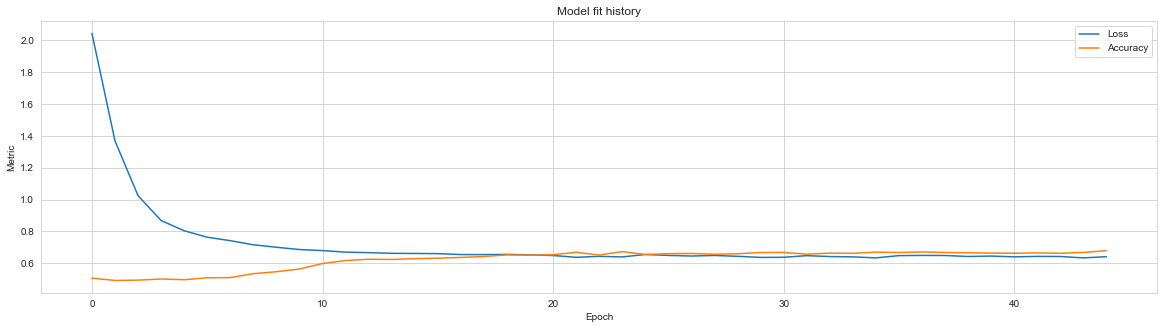

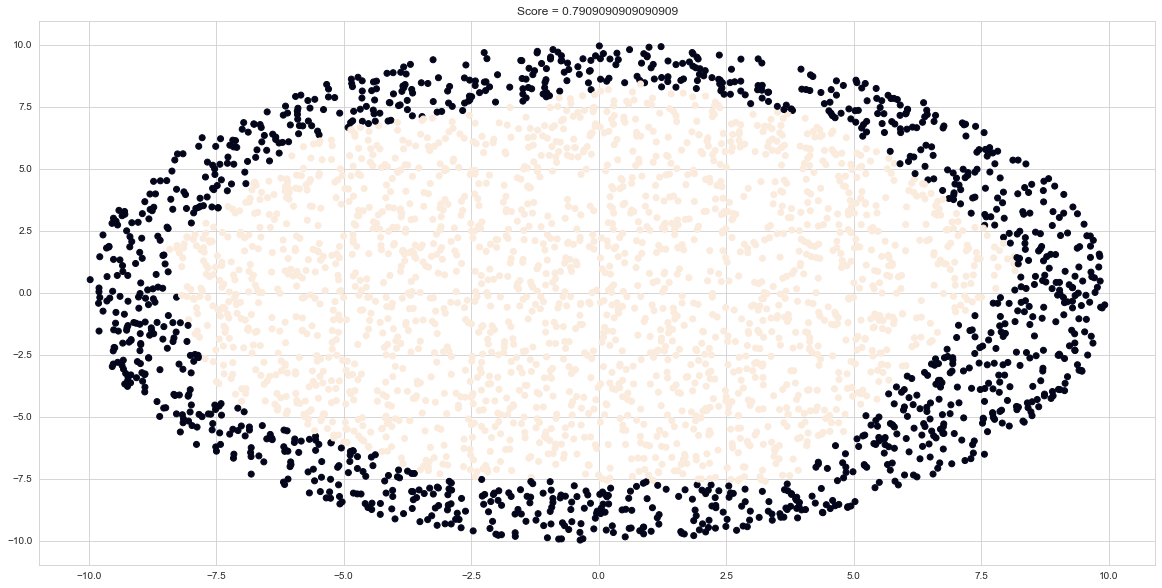

In [30]:
# optuna 'batch_size': 145, 'epochs': 45, 'activation': 'relu', 'kernel_initializer': 'random_uniform'
#########################################

def get_neural_model_opt():
    neural_model = Sequential()

    neural_model.add(L.Input(shape=X_test.shape[1]))

    neural_model.add(L.Dense(5, activation='relu', kernel_initializer='random_uniform'))
    neural_model.add(L.Dropout(0.5))
    neural_model.add(L.Dense(5, activation='relu', kernel_initializer='random_uniform'))
    neural_model.add(L.Dropout(0.5))

    neural_model.add(L.Dense(2, activation='relu'))

    optimizer = 'rmsprop'
    neural_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    return neural_model


std_scaler = StandardScaler()
std_scaler = std_scaler.fit(X_train)
X_train_std = std_scaler.transform(X_train)
X_test_std = std_scaler.transform(X_test)

my_first_neural_model = get_neural_model_opt()
fit_log = my_first_neural_model.fit(X_train_std, keras.utils.to_categorical(y_train),batch_size=145, epochs=45, workers=4, verbose=1)

predict_neural = my_first_neural_model.predict(X_test_std)
predict_classes = tf.argmax(predict_neural, axis=1).numpy()

score = accuracy_score(predict_classes, y_test)

print(f'Точность нашей модели {score}')
#########################################
plt.figure(figsize=(20, 5))
plt.title(f'Model fit history')
plt.xlabel('Epoch')
plt.ylabel('Metric')
plt.plot(fit_log.history['loss'], label='Loss')
plt.plot(fit_log.history['accuracy'], label='Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(20, 10))
plt.title(f'Score = {score}')
plt.scatter(X_test['x1'], X_test['x2'], c=predict_classes)
plt.show()